In [1]:
import torch
from torch import nn
import torch.nn.functional as F

In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

training_data = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=ToTensor()
)

from torch.utils.data import Dataset, DataLoader

dataloader = DataLoader(training_data, batch_size=128, shuffle=True)

In [3]:
class My_VGG(nn.Module):
    def __init__(self, activation="relu"):
        super().__init__()

        if activation == "tanh":
            self.activation = torch.tanh
        elif activation == "sigmoid":
            self.activation = torch.sigmoid
        elif activation == "relu":
            self.activation = torch.relu

        self.c0 = nn.Conv2d(1, 64, 3, 1)
        self.c1 = nn.Conv2d(64, 64, 4, 2, padding=1)
        self.c2 = nn.Conv2d(64, 128, 3, 1)
        self.c3 = nn.Conv2d(128, 128, 3, 2, padding=1)
        self.c4 = nn.Conv2d(128, 256, 3, 1)
        self.c5 = nn.Conv2d(256, 256, 4, 2, padding=1)
        self.fln = nn.Flatten()
        self.l0 = nn.Linear(256 * 4, 256)
        self.l1 = nn.Linear(256, 10)

    def forward(self, x):
        h = self.activation(self.c0(x))
        h = self.activation(self.c1(h))
        h = self.activation(self.c2(h))
        h = self.activation(self.c3(h))
        h = self.activation(self.c4(h))
        h = self.activation(self.c5(h))
        h = self.fln(h)
        h = self.activation(self.l0(h))
        h = self.l1(h)
        return h

    def get_perceptual_loss(self, x):
        h0 = self.activation(self.c0(x))
        h1 = self.activation(self.c1(h0))
        h2 = self.activation(self.c2(h1))
        h3 = self.activation(self.c3(h2))
        h4 = self.activation(self.c4(h3))
        h5 = self.activation(self.c5(h4))
        h51 = self.fln(h5)
        h6 = self.activation(self.l0(h51))
        return h0,h1,h2,h3,h4,h5,h6

In [4]:
from tqdm import tqdm

In [5]:
def get_cuda_device_or_cpu():
    if torch.cuda.is_available():
        cuda_count = torch.cuda.device_count()

        no = 0
        mem_available = 0

        for i in range(cuda_count):
            tmp_available = torch.cuda.mem_get_info(i)[0]
            if mem_available < tmp_available:
                no = i
                mem_available = tmp_available
        return f"cuda:{no}"
    return "cpu"

In [8]:
pl_model = My_VGG()
optimizer = torch.optim.Adam(pl_model.parameters())

device = get_cuda_device_or_cpu()
print(device)

pl_model.train()
pl_model.to(device)

for epoch in range(30):
    tl = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        # pred = pl_model(torch.clip(torch.randn_like(x) * 0.2 + x, 0, 1))
        pred = pl_model(x)
        loss = F.cross_entropy(pred, y)
        tl += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f'{epoch}: {tl}')

cuda:0
0: 89.78712695231661
1: 22.634877741103992
2: 16.39426510746125
3: 11.708893771428848
4: 10.290068239104585
5: 7.410097006155411
6: 6.97719326924198
7: 6.870504564190924
8: 6.188866183252685
9: 4.0781514110312855
10: 4.000457212529
11: 5.692478433995348
12: 3.9413605384170864
13: 4.012969617803719
14: 2.9297421692299395
15: 2.96262046191589
16: 3.301208972465247
17: 3.1615817092468887
18: 3.5283360824060424
19: 2.1335070542971835
20: 1.9340094790330724
21: 3.063662383331007
22: 2.5166765641778177
23: 1.7011925017458225
24: 1.968749256853613
25: 2.585785248744294
26: 1.685460882748103
27: 1.9118273243611483
28: 2.019190146191008
29: 1.4157610339826547


In [6]:
pl_model_f = My_VGG()
optimizer = torch.optim.Adam(pl_model_f.parameters())

device = get_cuda_device_or_cpu()
print(device)

pl_model_f.train()
pl_model_f.to(device)

for epoch in range(50):
    tl = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = pl_model_f(torch.clip(torch.randn_like(x) * 0.2 + x, 0, 1))
        # pred = pl_model_f(x)
        loss = F.cross_entropy(pred, y)
        tl += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f'{epoch}: {tl}')

cuda:0
0: 304.4962863624096
1: 188.2694706916809
2: 163.2734748274088
3: 151.17022635042667
4: 138.47008445858955
5: 130.78461354970932
6: 123.8259853348136
7: 116.06088718771935
8: 111.21596379578114
9: 106.70725324749947
10: 100.1442134231329
11: 95.76280354708433
12: 92.45686243474483
13: 88.22667035460472
14: 85.43590861558914
15: 80.11349991708994
16: 78.0601356998086
17: 74.8337429240346
18: 71.84175511822104
19: 69.38699871301651
20: 67.85309048742056
21: 64.7967759333551
22: 64.23883776552975
23: 61.51939757913351
24: 60.45173570141196
25: 57.57465913519263
26: 55.8071712590754
27: 55.33281074650586
28: 53.46081633120775
29: 52.613978043198586
30: 51.396465957164764
31: 49.13141083531082
32: 48.083955055102706
33: 47.37044785358012
34: 46.36886769533157
35: 45.833491664379835
36: 44.54655430652201
37: 43.04319503903389
38: 42.31709066033363
39: 42.0571514070034
40: 40.69815729930997
41: 40.57530455850065
42: 39.979624630883336
43: 39.65769412694499
44: 37.57742843683809
45: 38.

In [7]:
for epoch in range(30):
    tl = 0
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = pl_model_f(torch.clip(torch.randn_like(x) * 0.2 + x, 0, 1))
        # pred = pl_model_f(x)
        loss = F.cross_entropy(pred, y)
        tl += loss.item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    print(f'{epoch}: {tl}')

0: 34.90450209751725
1: 35.69191638473421
2: 35.28135105315596
3: 33.53895540907979
4: 34.012550150975585
5: 33.817200222983956
6: 32.251609531231225
7: 32.54713821876794
8: 31.476971976459026
9: 31.311630911193788
10: 31.720406400971115
11: 30.593832195736468
12: 31.685398664325476
13: 30.16235642042011
14: 29.855614703148603
15: 30.09940009471029
16: 29.330478191841394
17: 29.919478823430836
18: 29.057738799368963
19: 27.979849595576525
20: 27.896871543955058
21: 28.439645759761333
22: 29.04400431131944
23: 26.686420595739037
24: 29.519394673407078
25: 26.967069491976872
26: 27.471649572253227
27: 26.718955274671316
28: 27.466800461988896
29: 26.503165152389556


In [8]:
from myAE import Manager

manager = Manager()
manager.prepare_data()

/home/secondvoca/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [44]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    pl_x = pl_model_f.get_perceptual_loss(x)
    pl_pred = pl_model_f.get_perceptual_loss(pred)
    ll = 0
    # rate = 1.
    for px, pp in zip(pl_x[1:2], pl_pred[1:2]):
        ll += F.mse_loss(pp, px, reduction='sum') / len(x)
        # ll += rate * F.mse_loss(pp, px, reduction='sum') / len(x)
        # rate /= 64
    # ll += F.binary_cross_entropy(pred, x, reduction='sum') / (1 * len(x))
    loss = ll + kl
    return loss

manager.set_default_model(4, 2)
device = get_cuda_device_or_cpu()
pl_model_f.to(device)
hist = manager.train(calc_loss, epochs=30)
manager.add_model('pl f 1:2 30')

Now, it is working on cuda:0.


  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [04:30<00:00,  9.03s/it]


In [11]:
def calc_loss(model, x, y, F, device):
    h = model.get_submodule("encoder")(x)
    mu = h[:, :2]
    log_sigma = h[:, 2:4]
    sigma = log_sigma.exp()
    z = torch.rand_like(mu, device=device) * sigma + mu
    pred = model.get_submodule("decoder")(z)
    kl = 0.5*(mu.square() + sigma.square() - log_sigma - 1).sum(dim=1).mean()
    ll = F.binary_cross_entropy(pred, x, reduction='sum')/len(x)
    loss = ll + kl
    return loss

manager.set_default_model(4, 2)
hist = manager.train(calc_loss, epochs=30)
manager.add_model('vanilla 30')

Now, it is working on cuda:0.


100%|██████████| 30/30 [02:50<00:00,  5.69s/it]


In [12]:
import matplotlib.pyplot as plt

In [13]:
def compare_with_vanilla(manager, name, original_name='vanilla 30'):
    fig, (axs1, axs2, axs3) = plt.subplots(nrows=3, ncols=5, figsize=[20, 13])

    manager.swap_current_model(original_name)
    manager.model.to('cpu')
    manager.model.eval()

    for x, y in manager.train_dataloader:
        with torch.no_grad():
            h = manager.model.get_submodule("encoder")(x)
            mu = h[:, :2]
            x_hats = manager.model.get_submodule("decoder")(mu)
        for ax, img in zip(axs1, x[:5]):
            ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
        for ax, img in zip(axs2, x_hats):
            ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')

        
        with torch.no_grad():
            manager.swap_current_model(name)

            manager.model.to('cpu')
            manager.model.eval()

            h = manager.model.get_submodule("encoder")(x)
            mu = h[:, :2]
            x_hats = manager.model.get_submodule("decoder")(mu)
        for ax, img in zip(axs3, x_hats):
            ax.imshow(img.view([28, 28]), cmap='gray', vmin=0, vmax=1)
            ax.axis('off')
        
        break
    plt.tight_layout()

아웃라이어 뽑아보기

In [70]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)
x_ori = training_data.data / training_data.data.max().to(torch.float)
x_ori.max()

tensor(1.)

In [78]:
print(x_ori.shape)

torch.Size([60000, 28, 28])


In [72]:
x_idx = torch.arange(0, len(x_ori)).to(torch.long)
x_idx.shape

torch.Size([60000])

In [83]:
model_name = 'pl f :1 30'
manager.swap_current_model(model_name)
manager.model.eval()
manager.model.to('cpu')
pl_model_f.to('cpu')

with torch.no_grad():
    h = manager.model.get_submodule("encoder")(x_ori.view(-1, 1, 28, 28))
    mu = h[:, :2]
    pred = manager.model.get_submodule("decoder")(mu)
    pl_x = pl_model_f.get_perceptual_loss(x_ori.view(-1, 1, 28, 28))
    pl_pred = pl_model_f.get_perceptual_loss(pred.view(-1, 1, 28, 28))
    ll = 0
    # rate = 1.
    for px, pp in zip(pl_x[:2], pl_pred[:2]):
        ll += F.mse_loss(pp, px, reduction='none')
    ll = ll.view(60000, -1).sum(dim=1)

    n_ll = (ll - ll.mean()) / ll.std()
    outliers = x_idx[n_ll > 3]
    print(outliers.shape)

RuntimeError: The size of tensor a (26) must match the size of tensor b (13) at non-singleton dimension 3

In [81]:
def show_images(images, indices):
    nr = len(indices) // 10 + 1
    imgs = images[indices]
    imgs = torch.cat([imgs, torch.ones(nr * 10 - len(imgs), 28, 28)])

    _, axs = plt.subplots(nr, 10, figsize=[20, 2 * nr])
    
    for ax, img in zip(axs.flat, imgs):
        ax.imshow(img, cmap='gray', vmax=1, vmin=0)
        ax.axis('off')
    plt.tight_layout()


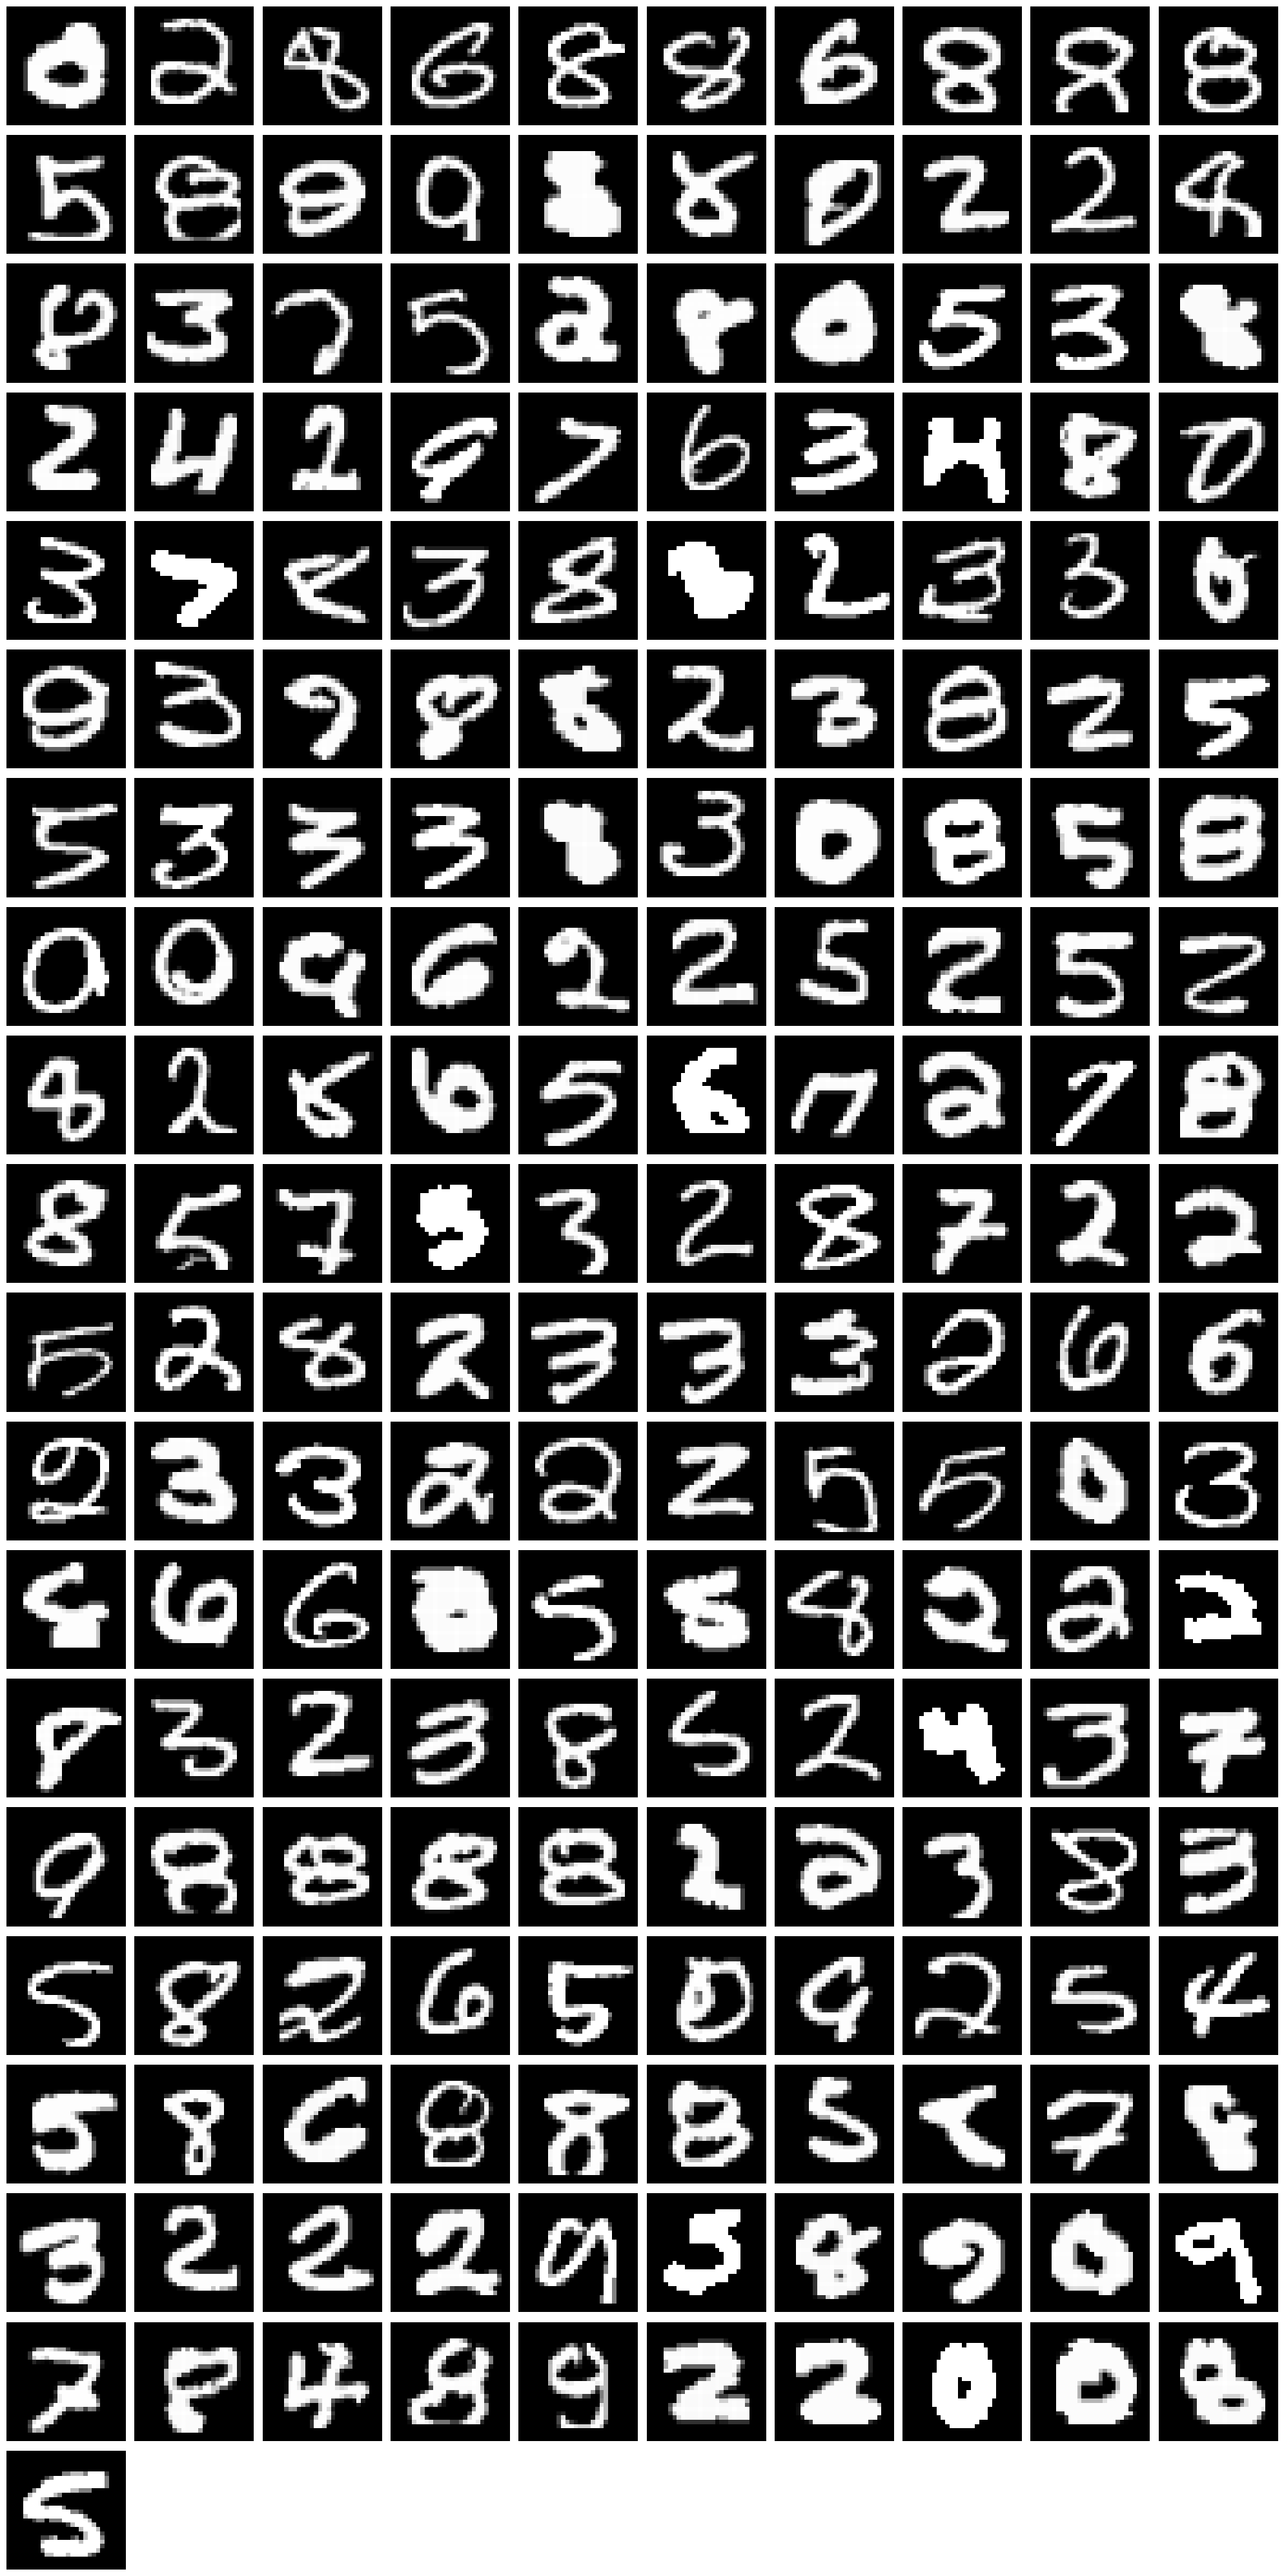

In [82]:
show_images(x_ori, outliers)

새 실험

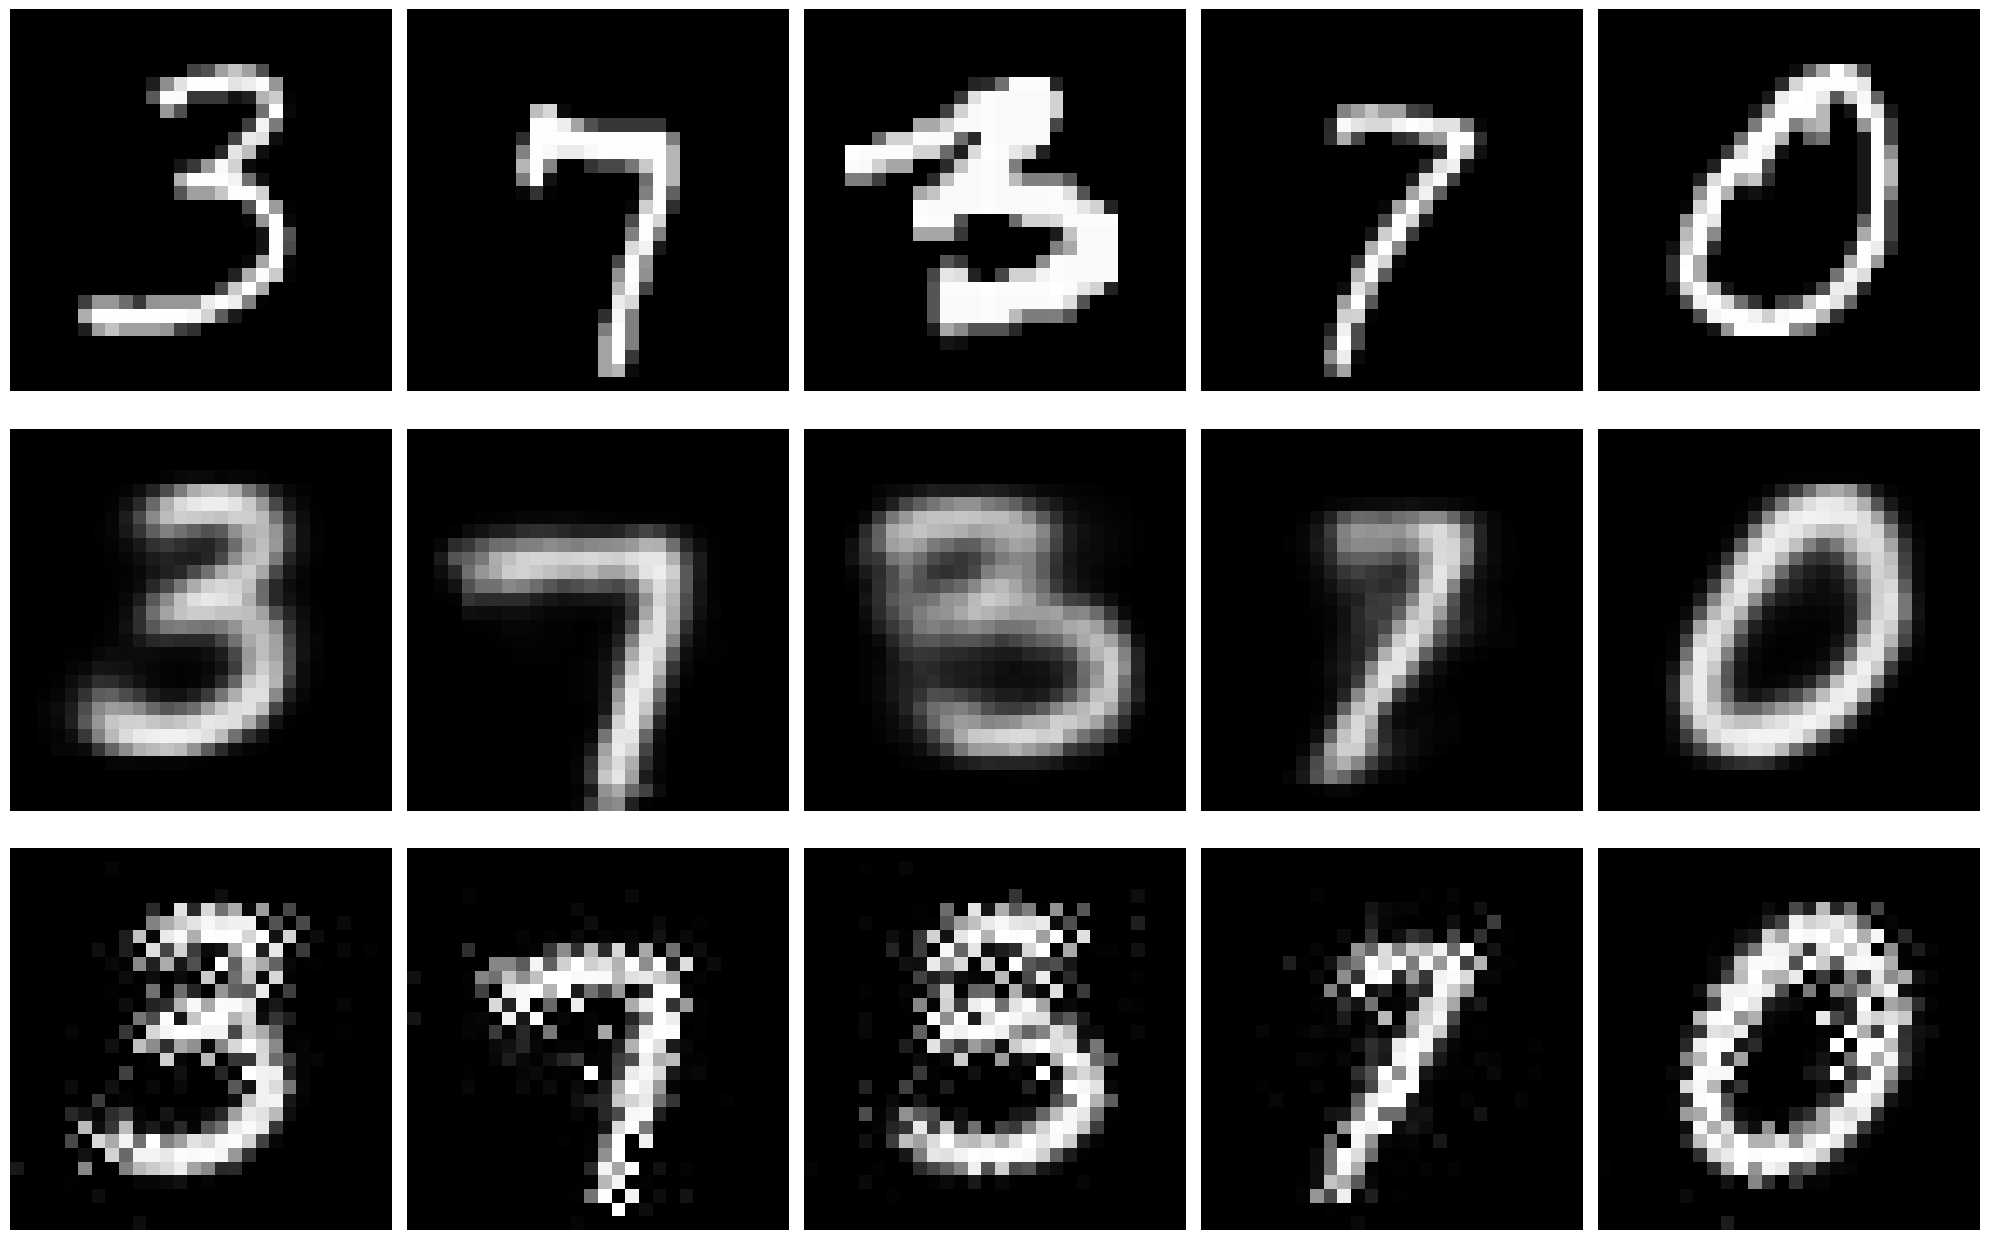

In [54]:
compare_with_vanilla(manager, 'pl f 1:2 30')

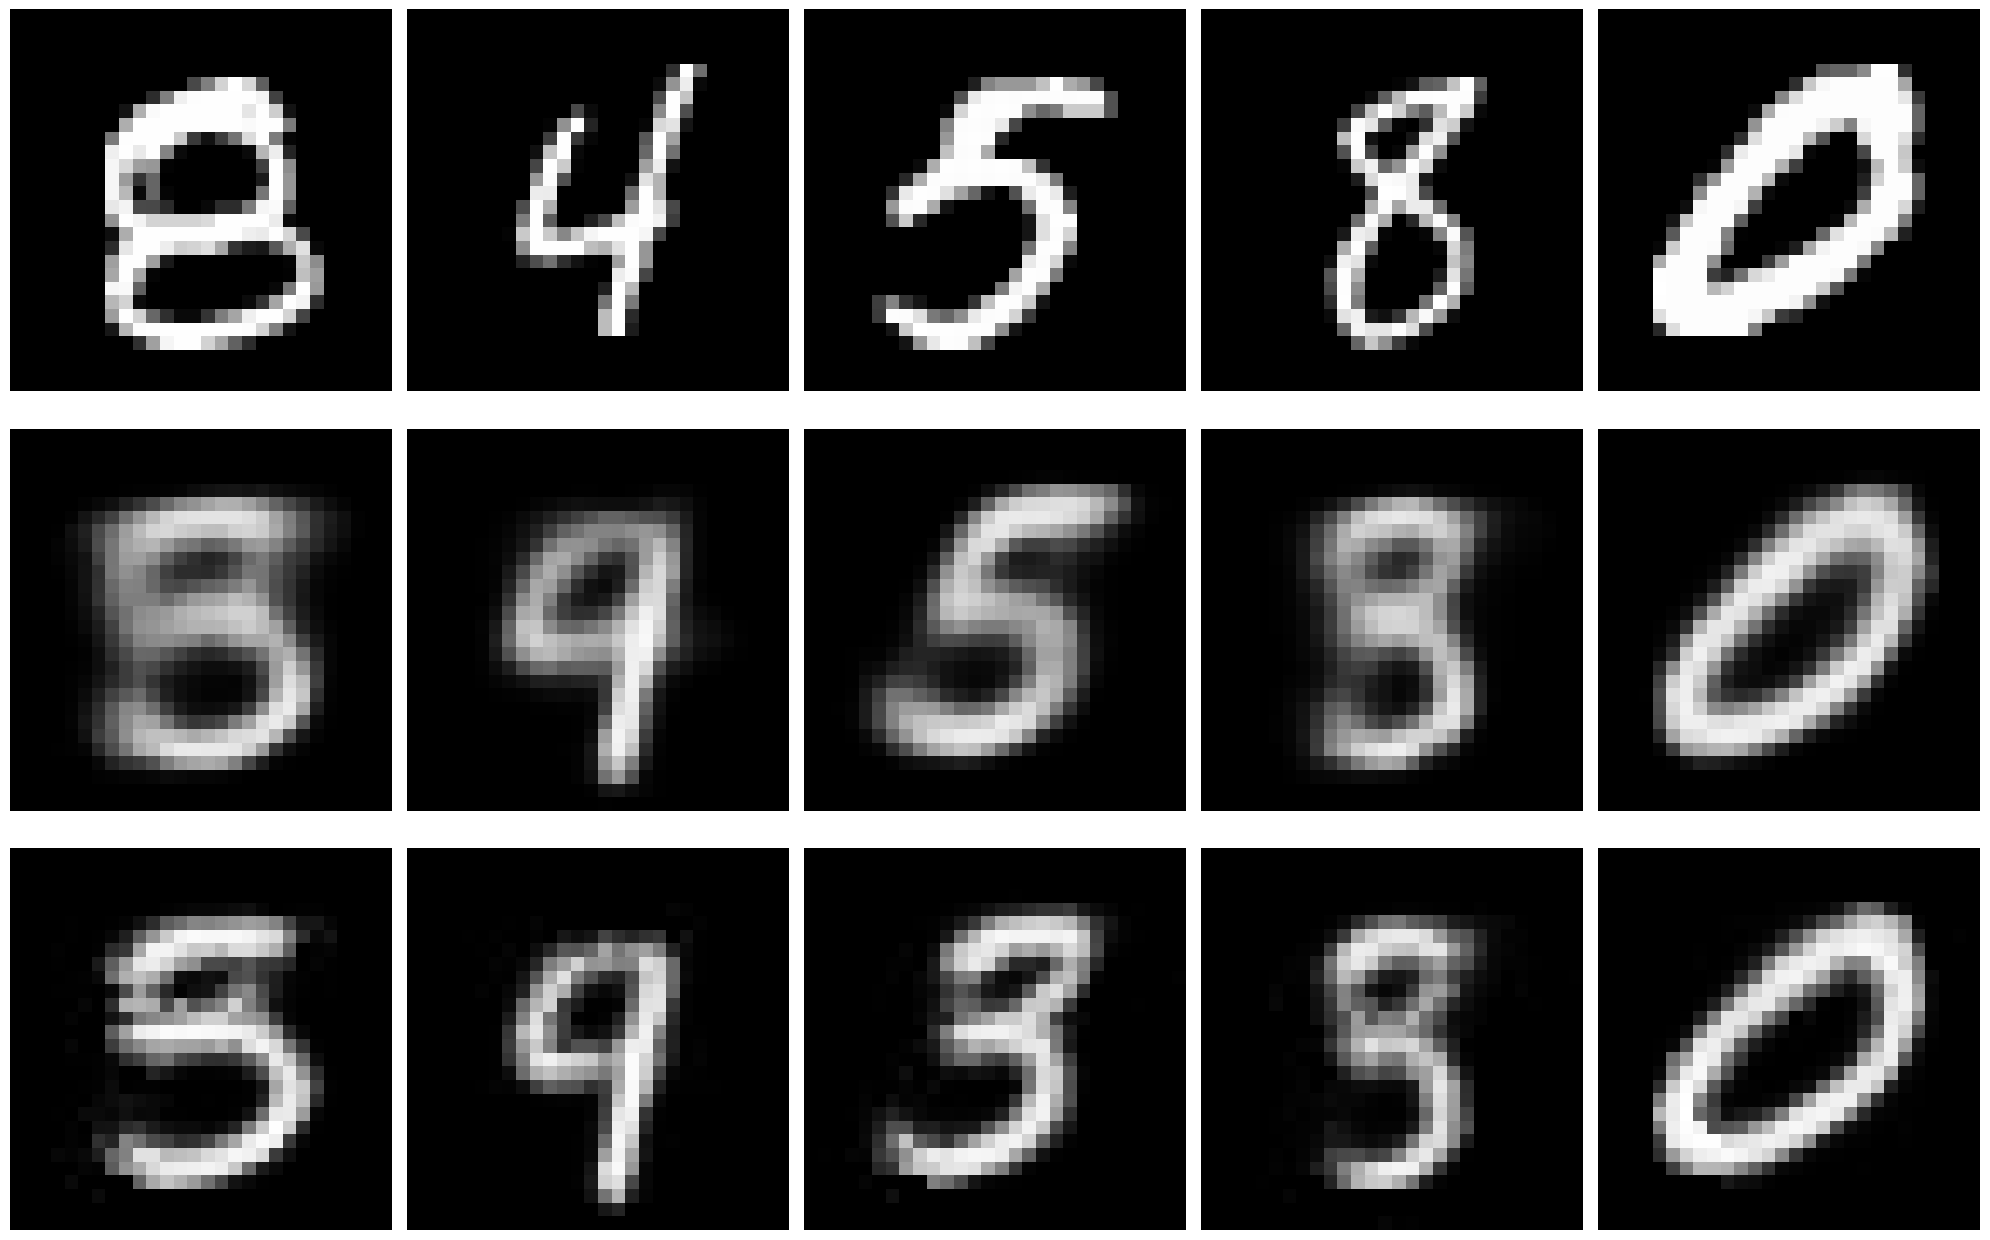

In [94]:
compare_with_vanilla(manager, 'pl f :1 30')

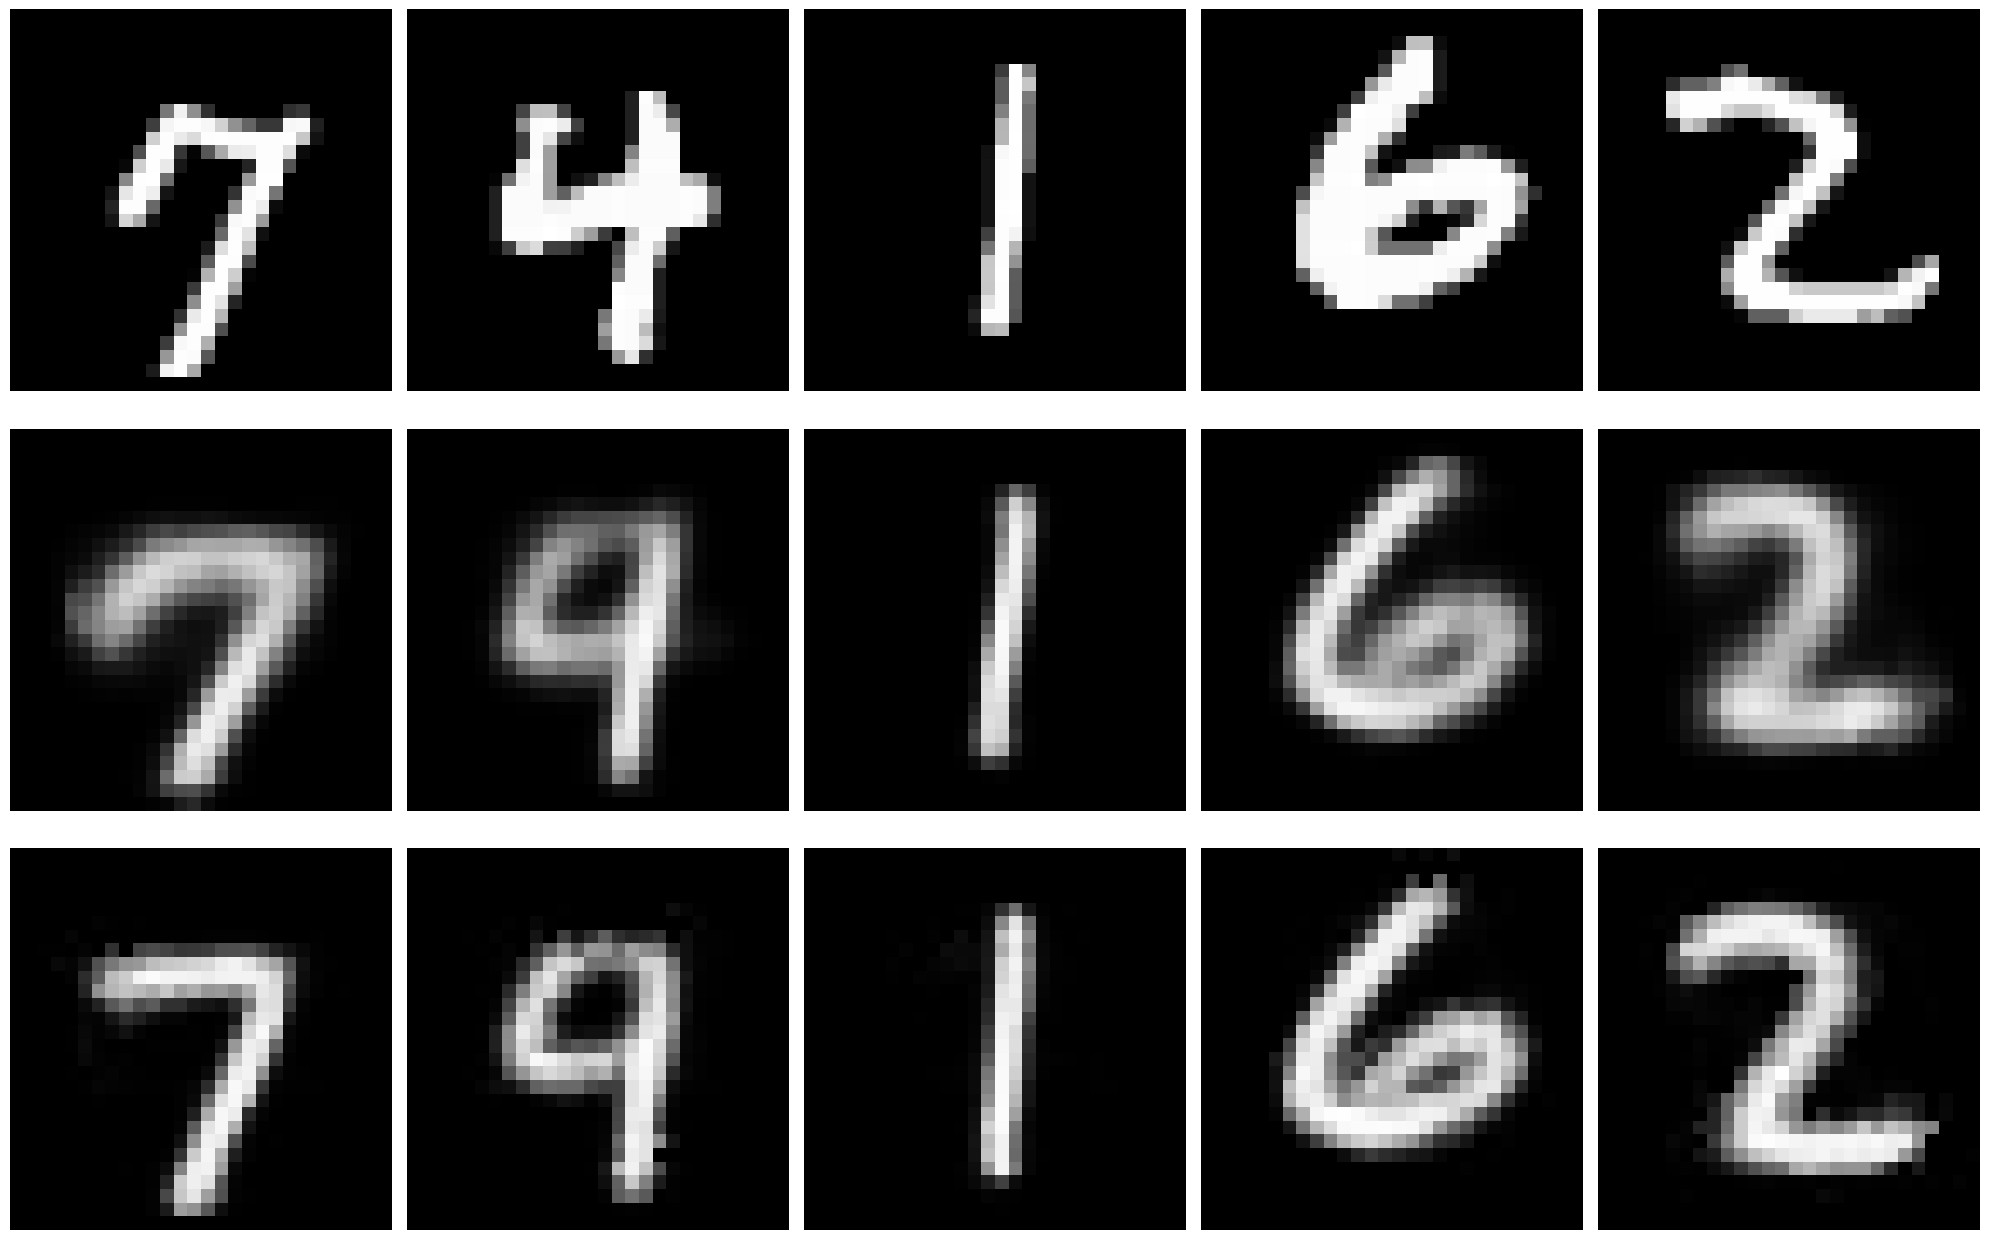

In [90]:
compare_with_vanilla(manager, 'pl f :1 30')

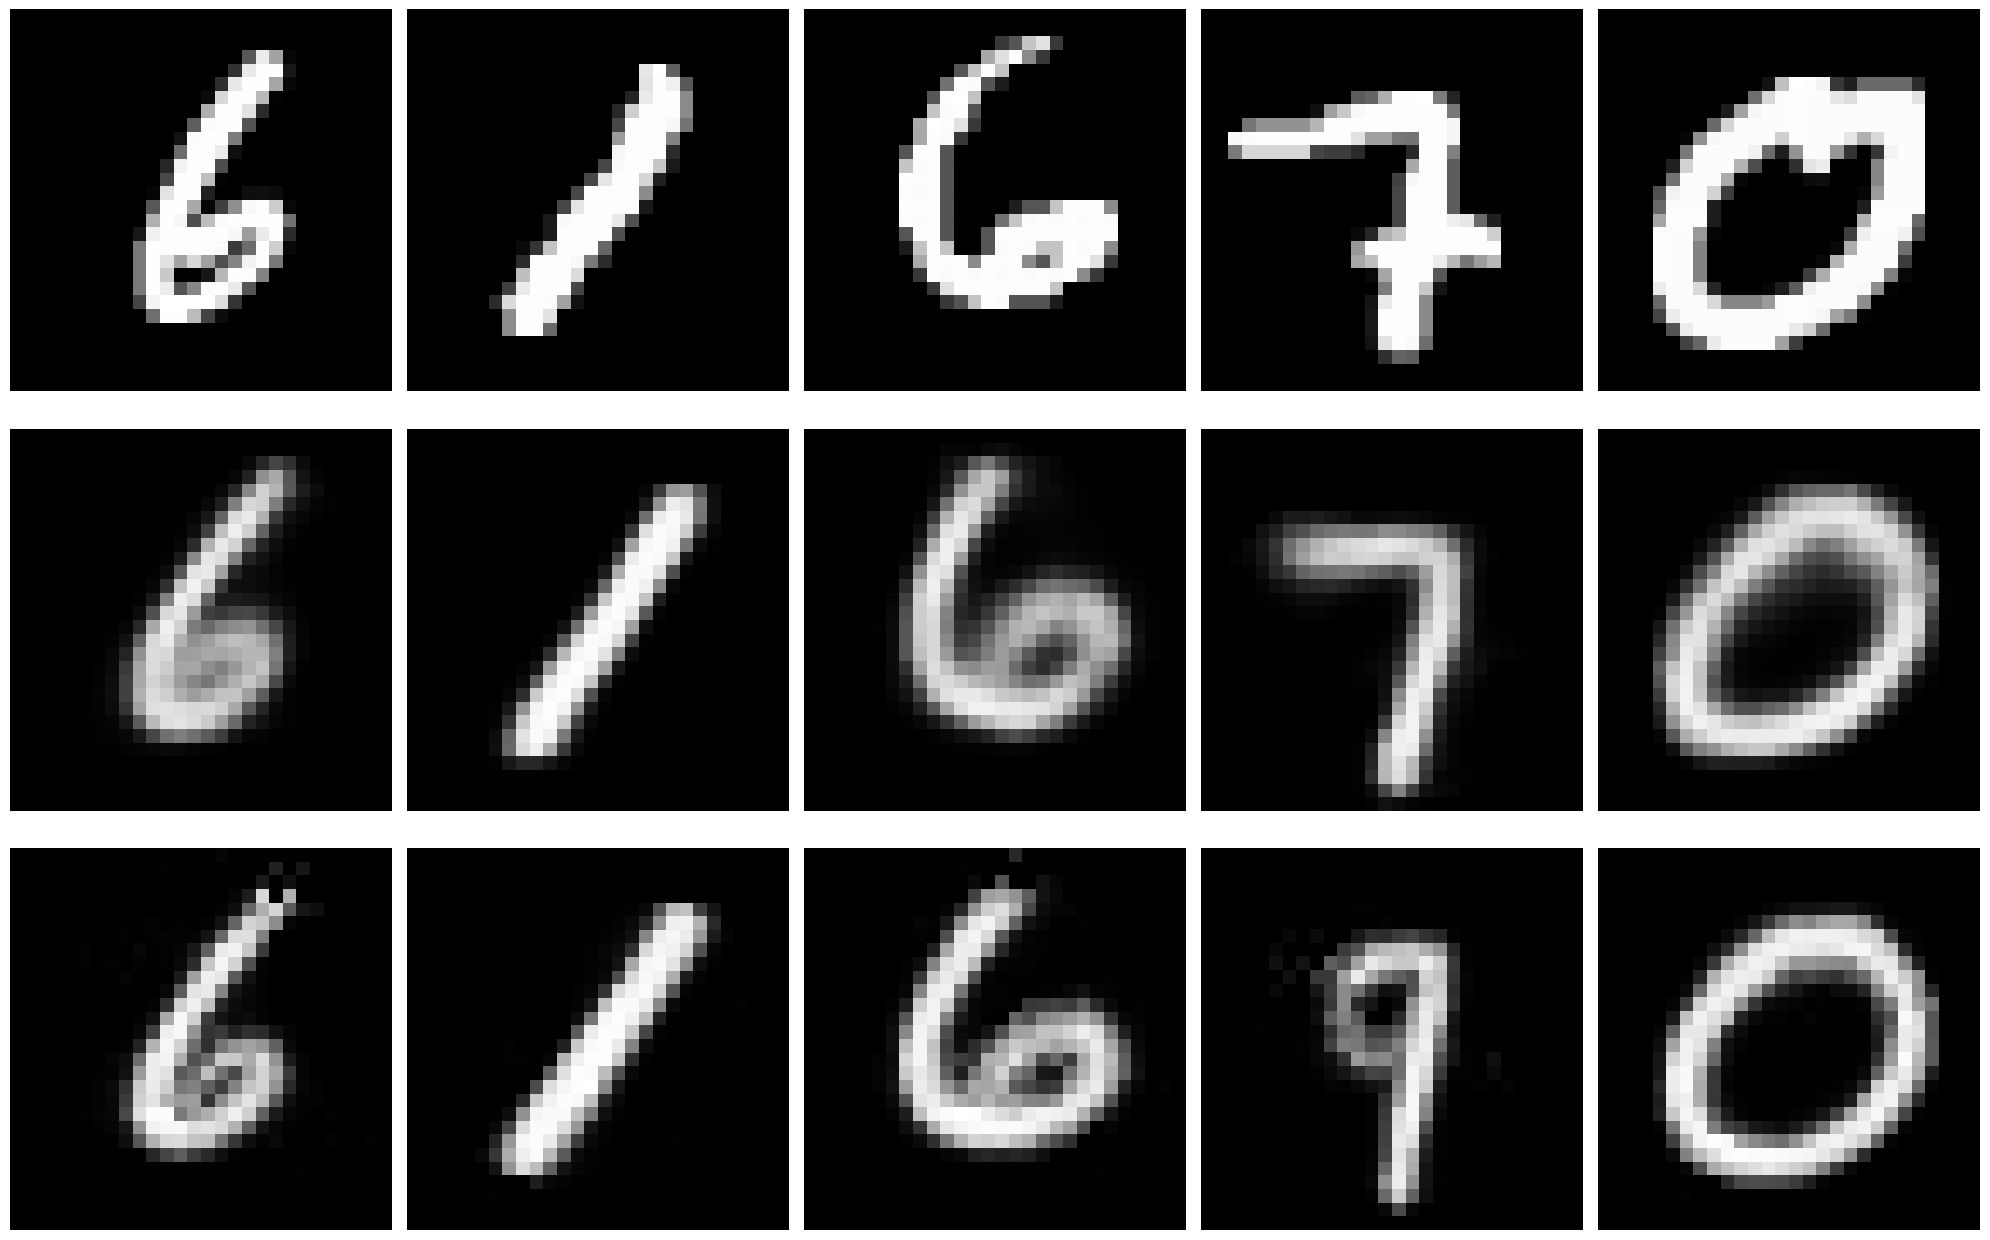

In [27]:
compare_with_vanilla(manager, 'pl f rate 64 30')

이 밑은 옛날 거(fashion 30)

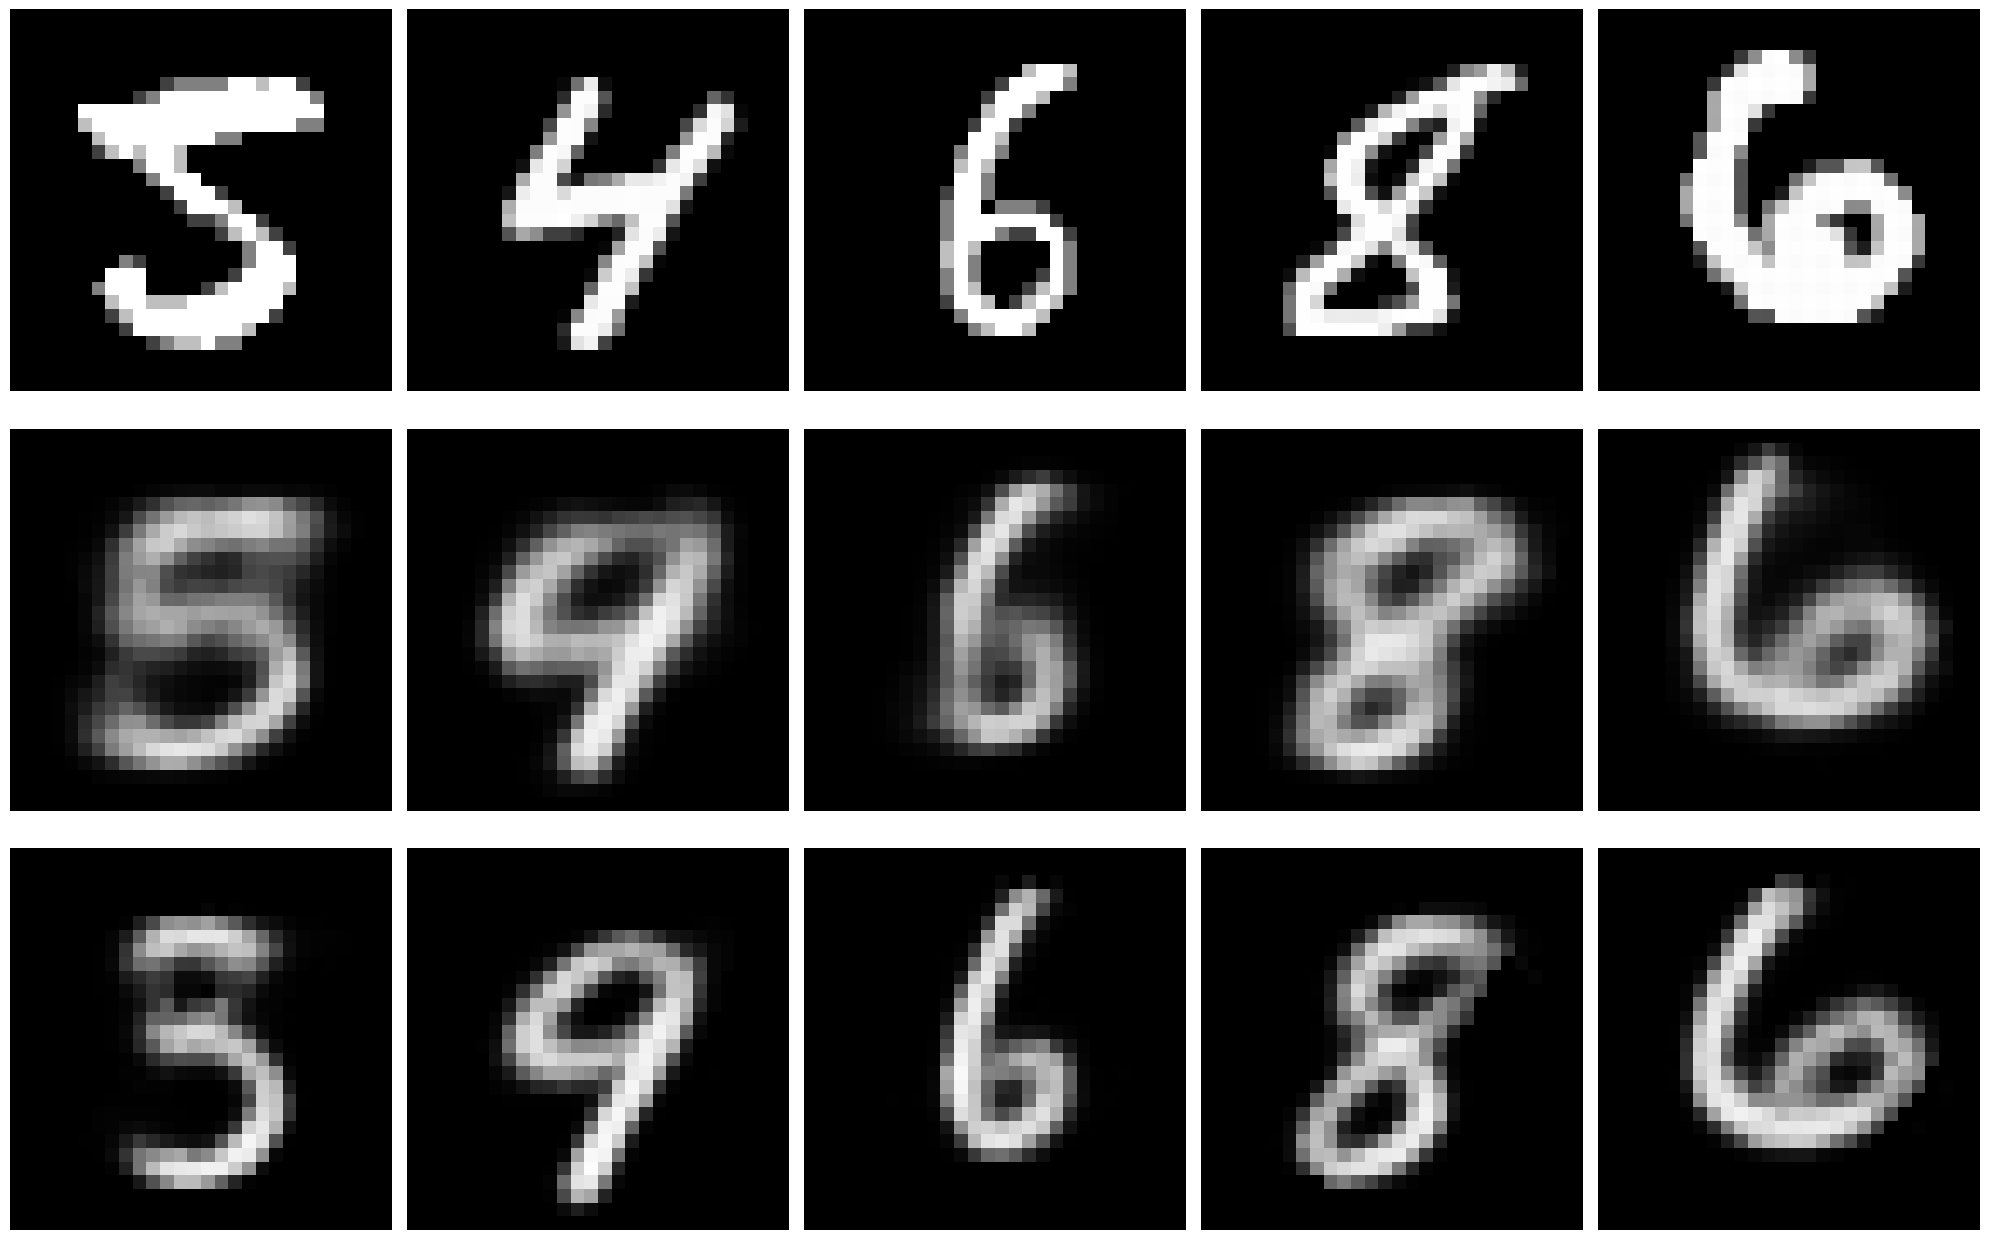

In [451]:
compare_with_vanilla(manager, 'pl f rate 64 30')

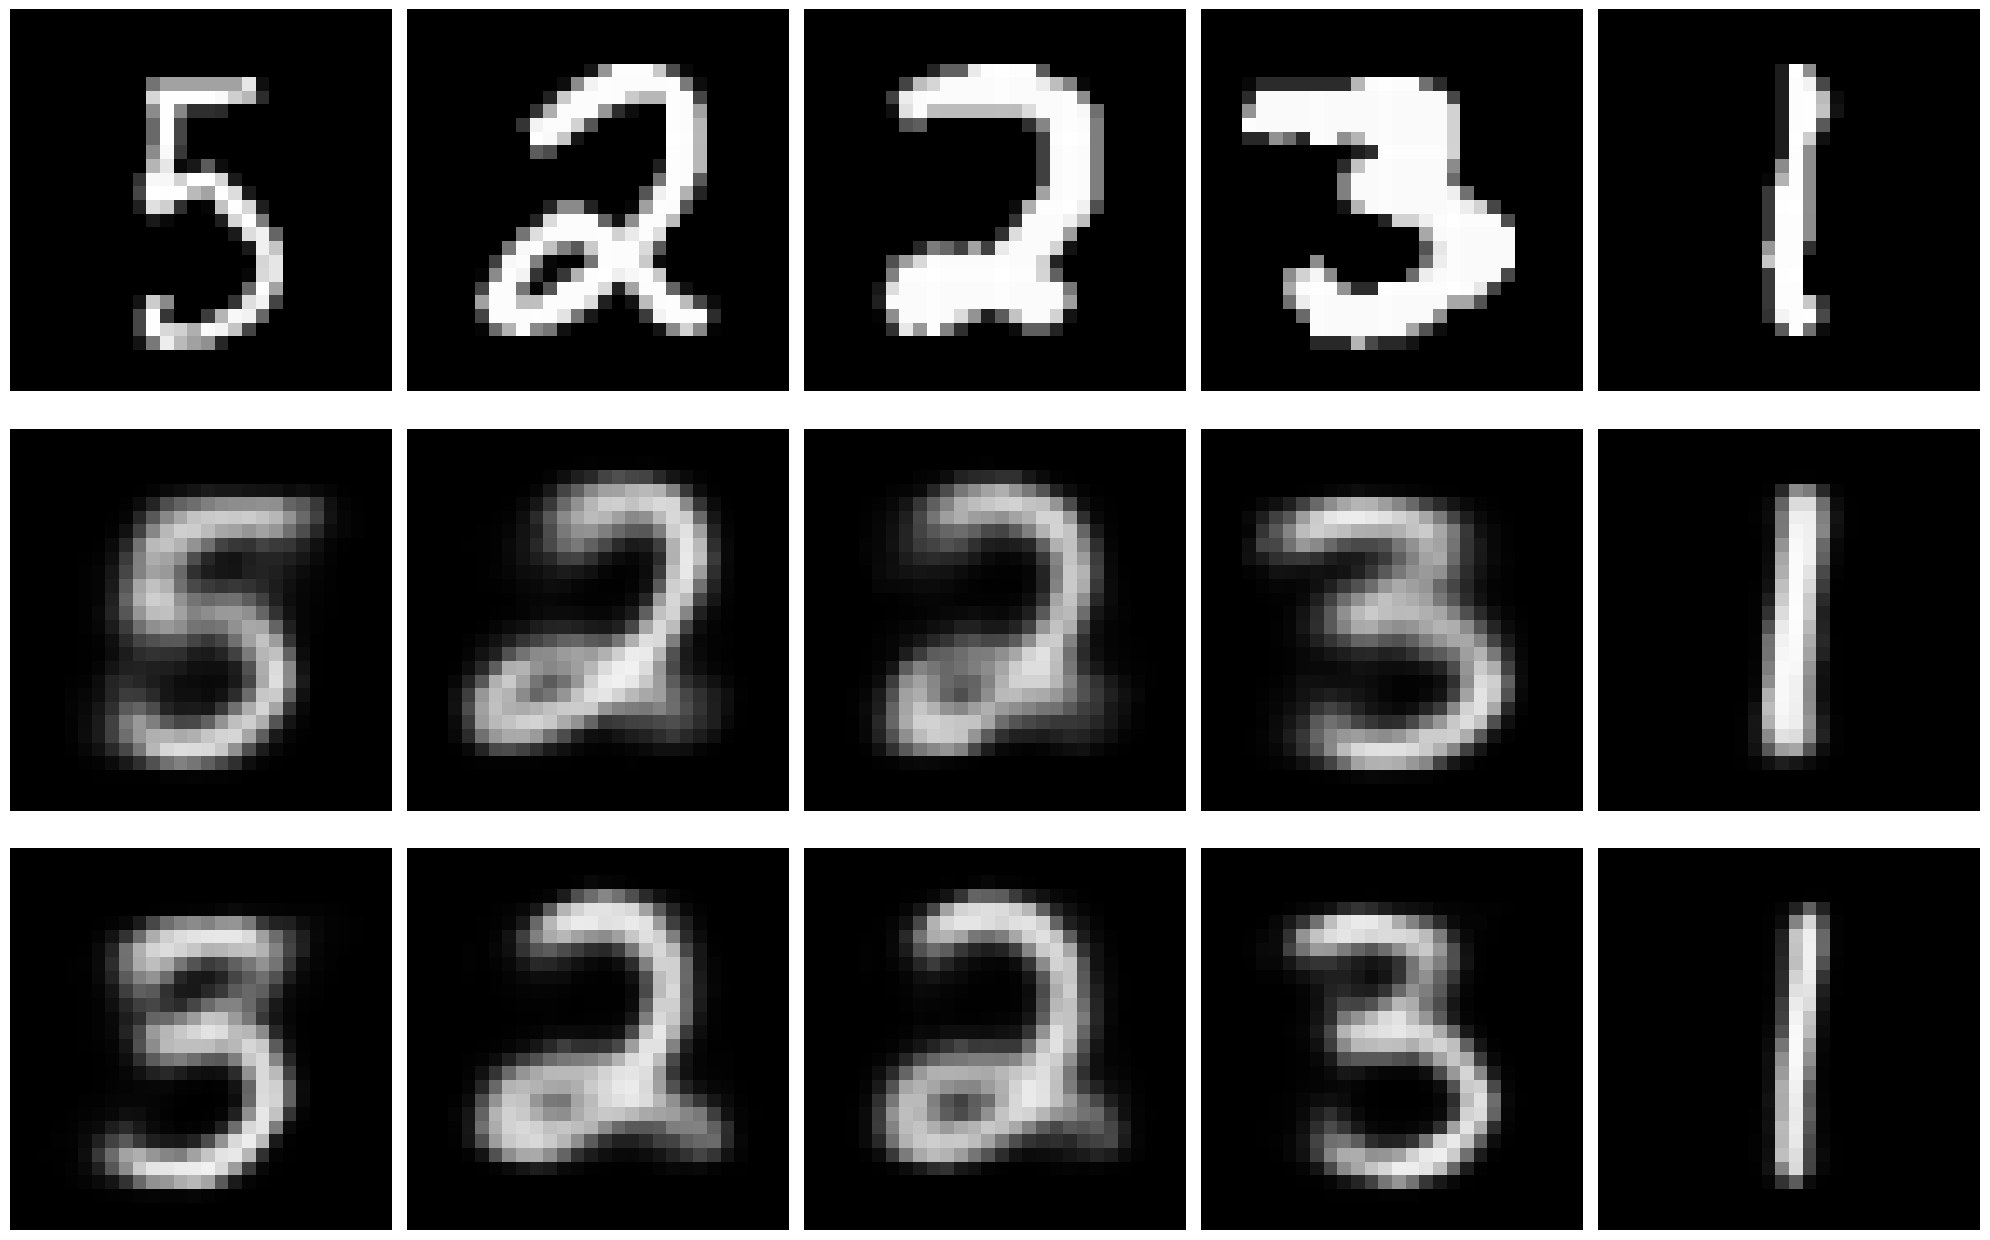

In [380]:
compare_with_vanilla(manager, 'pl f :1 +ce 30')

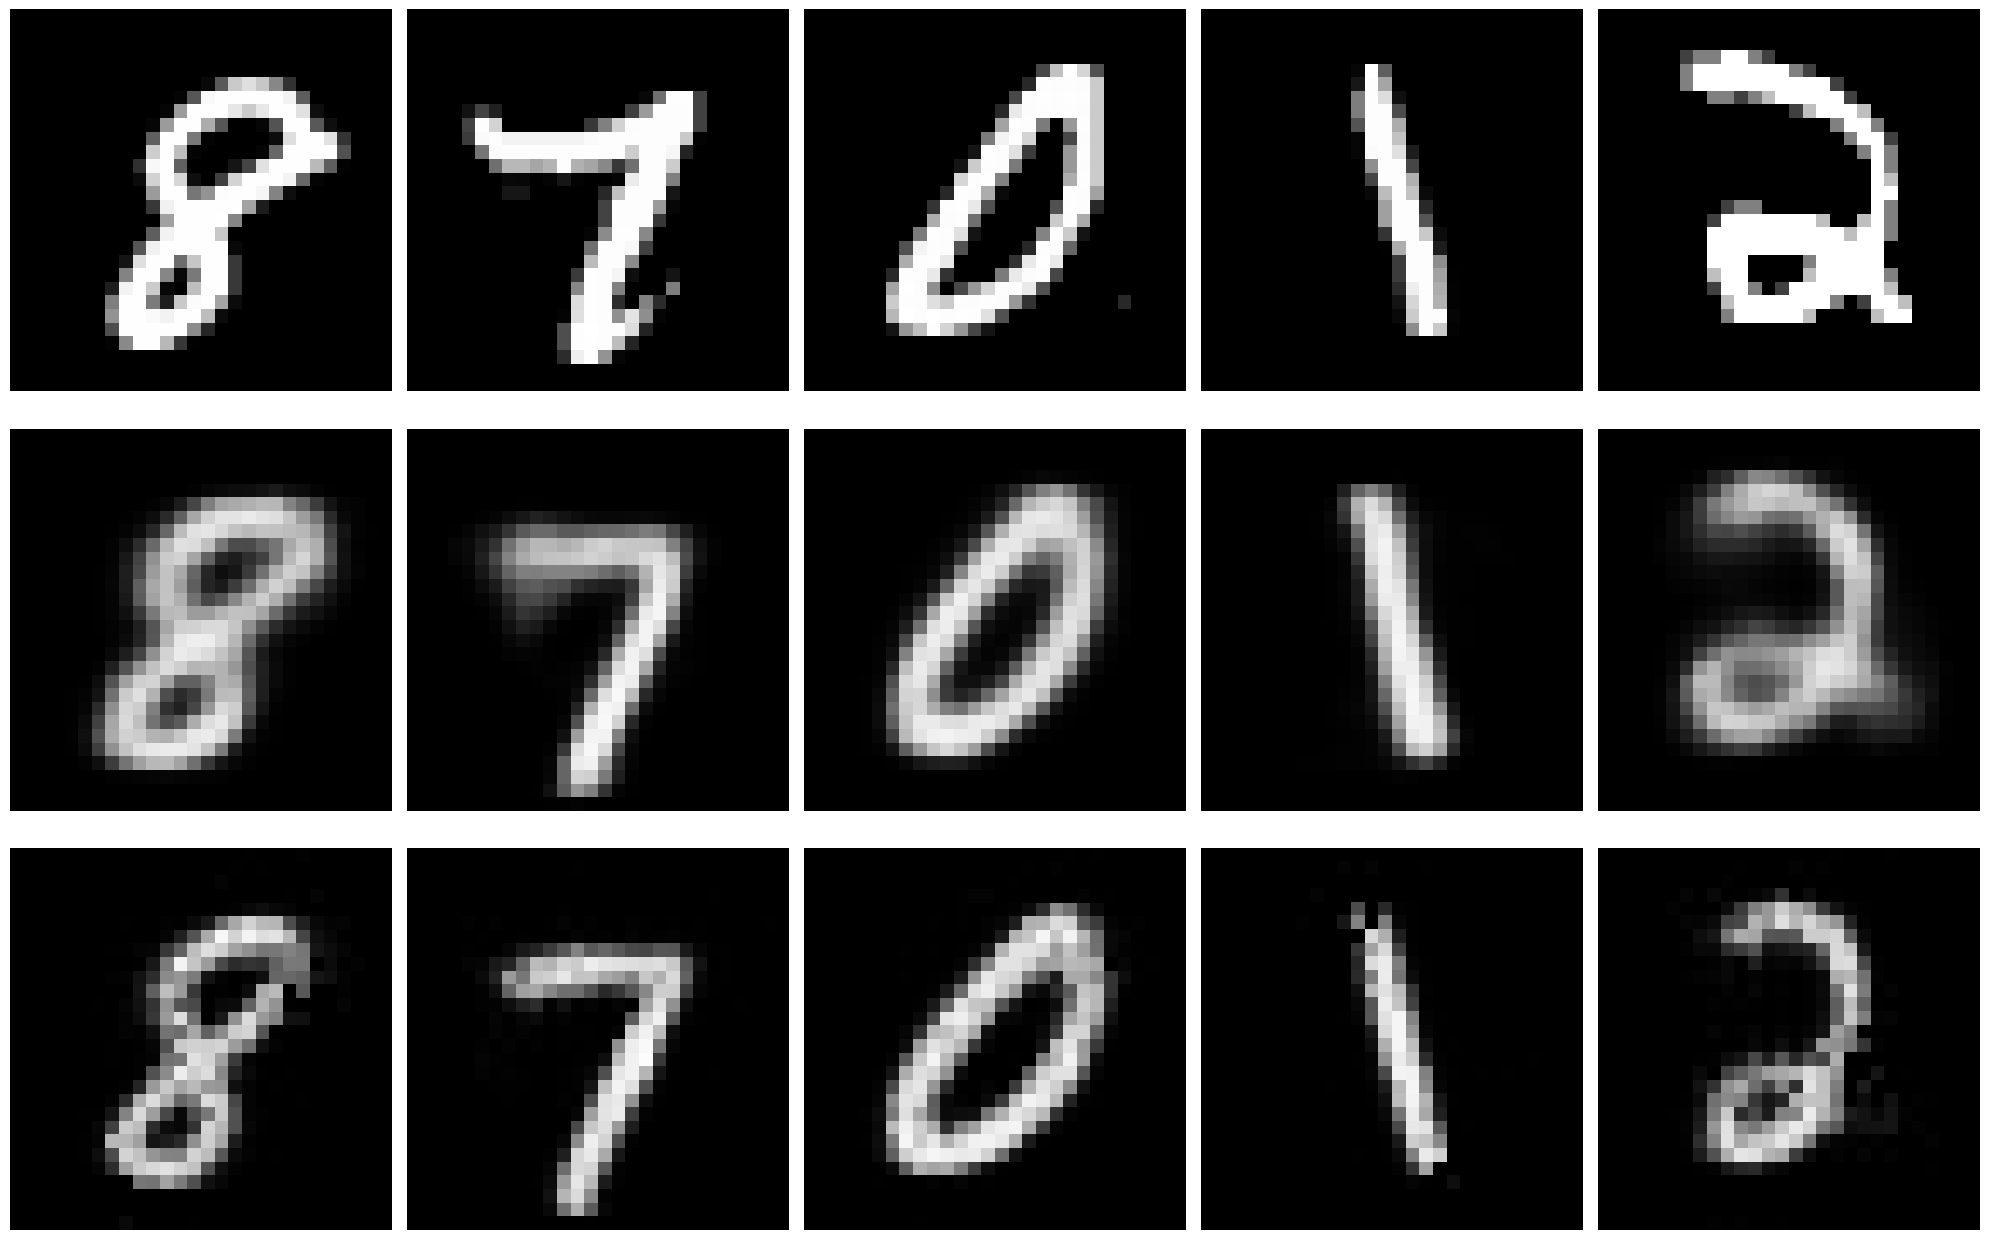

In [356]:
compare_with_vanilla(manager, 'pl f :2 30')

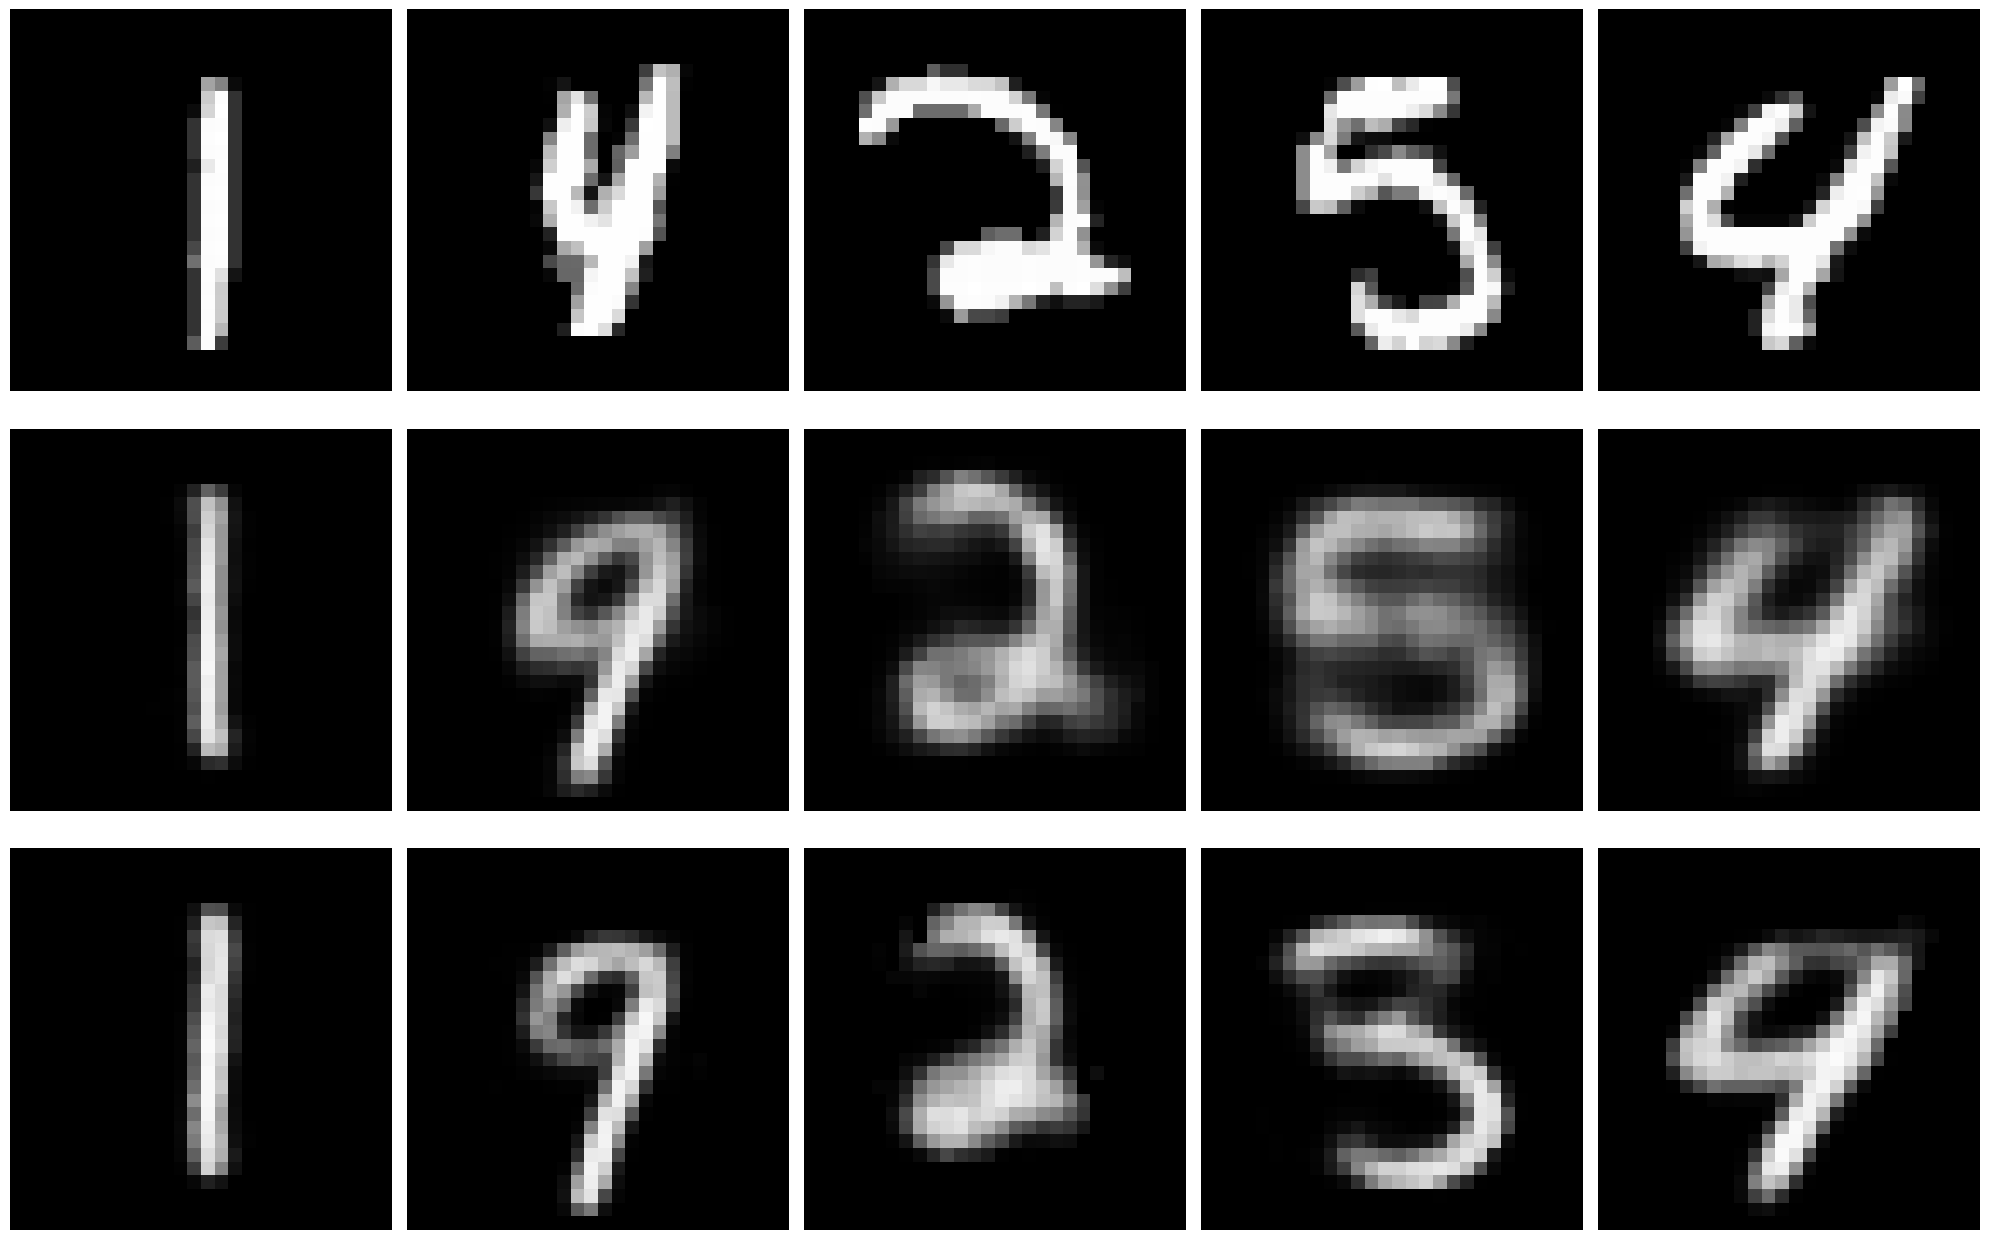

In [395]:
compare_with_vanilla(manager, 'pl f :1 30')

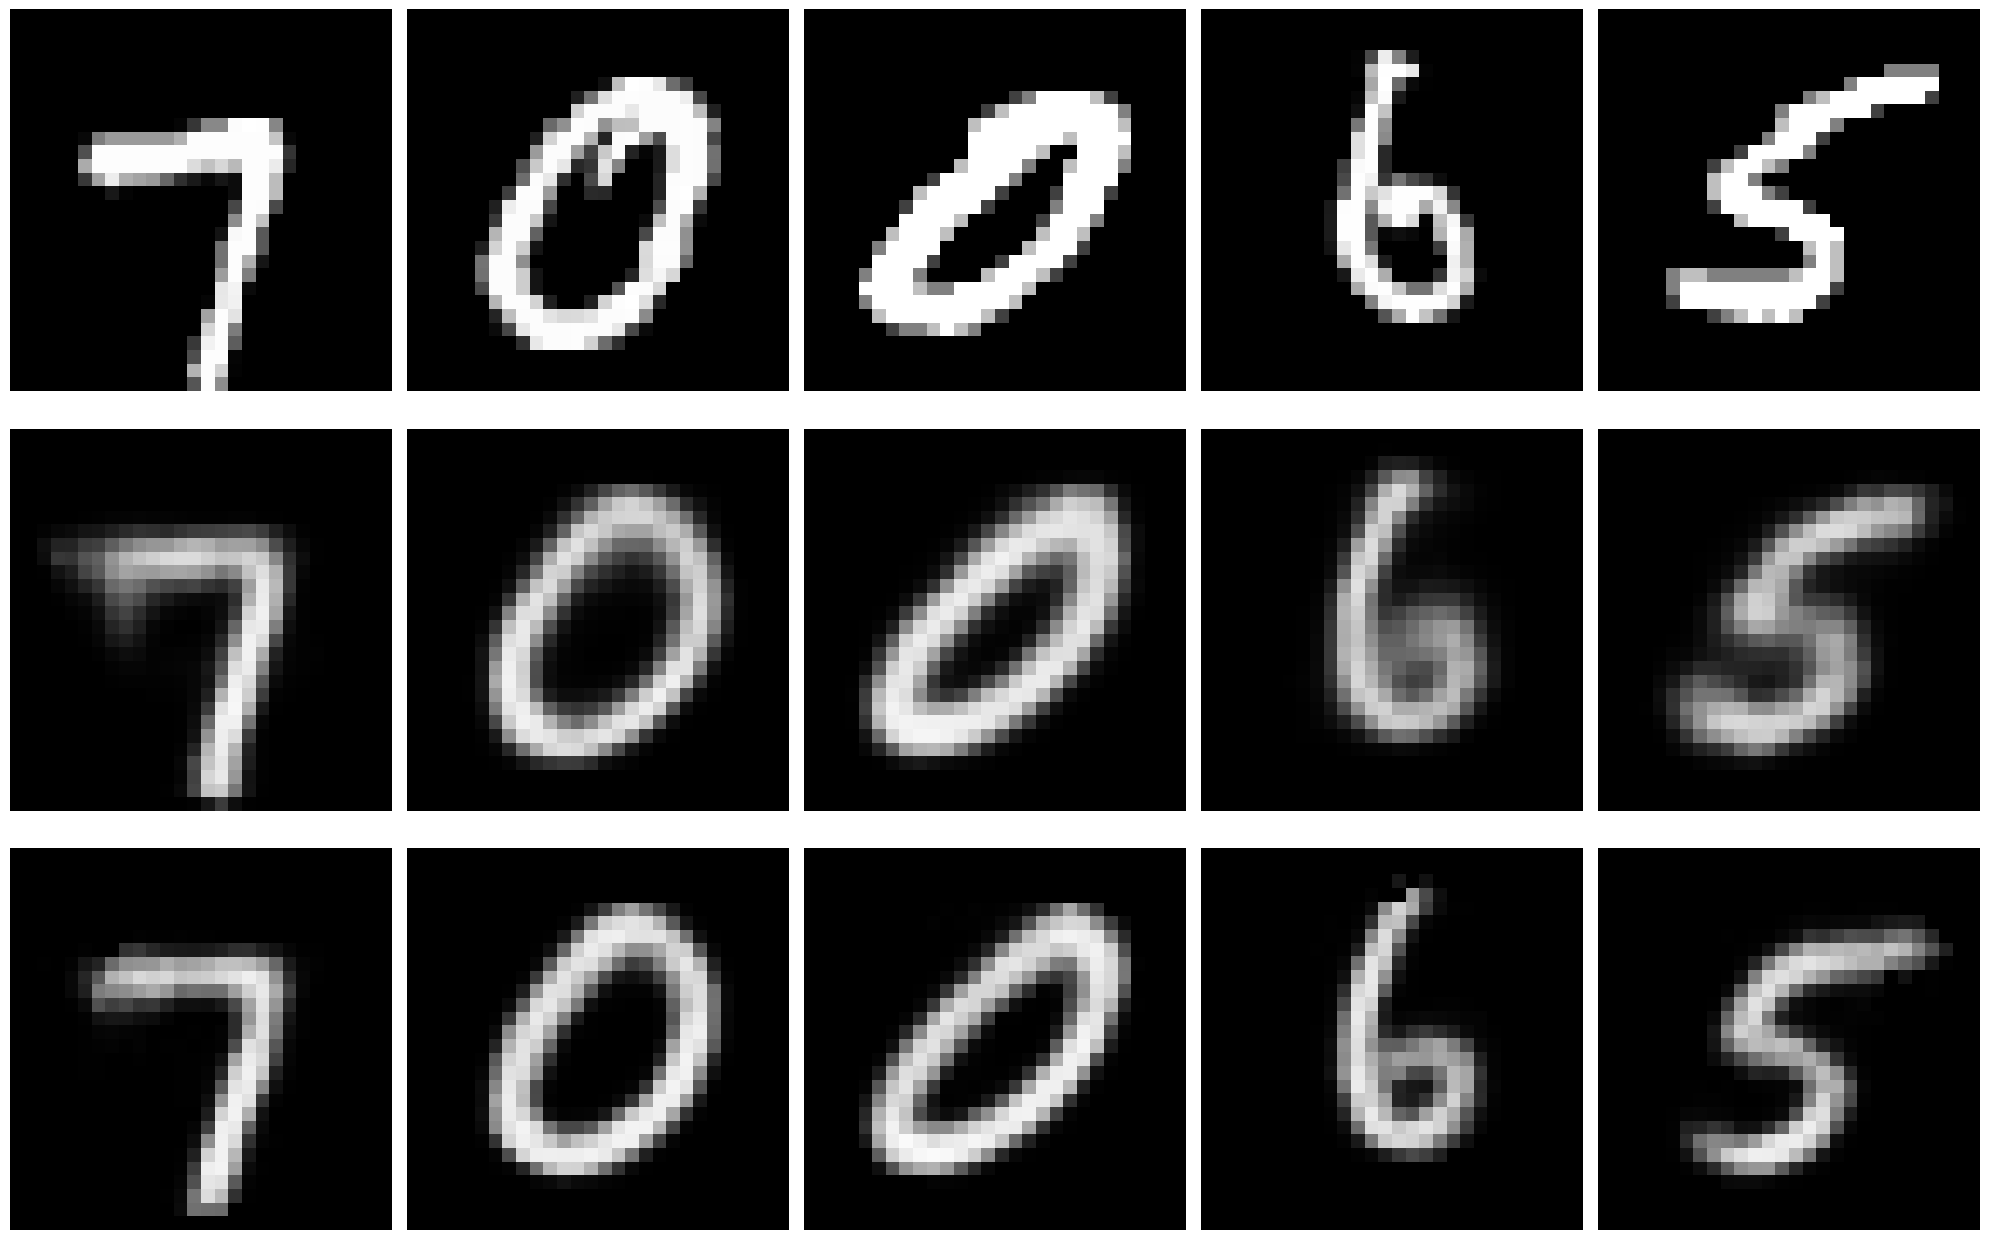

In [419]:
compare_with_vanilla(manager, 'pl f rate 32 30')

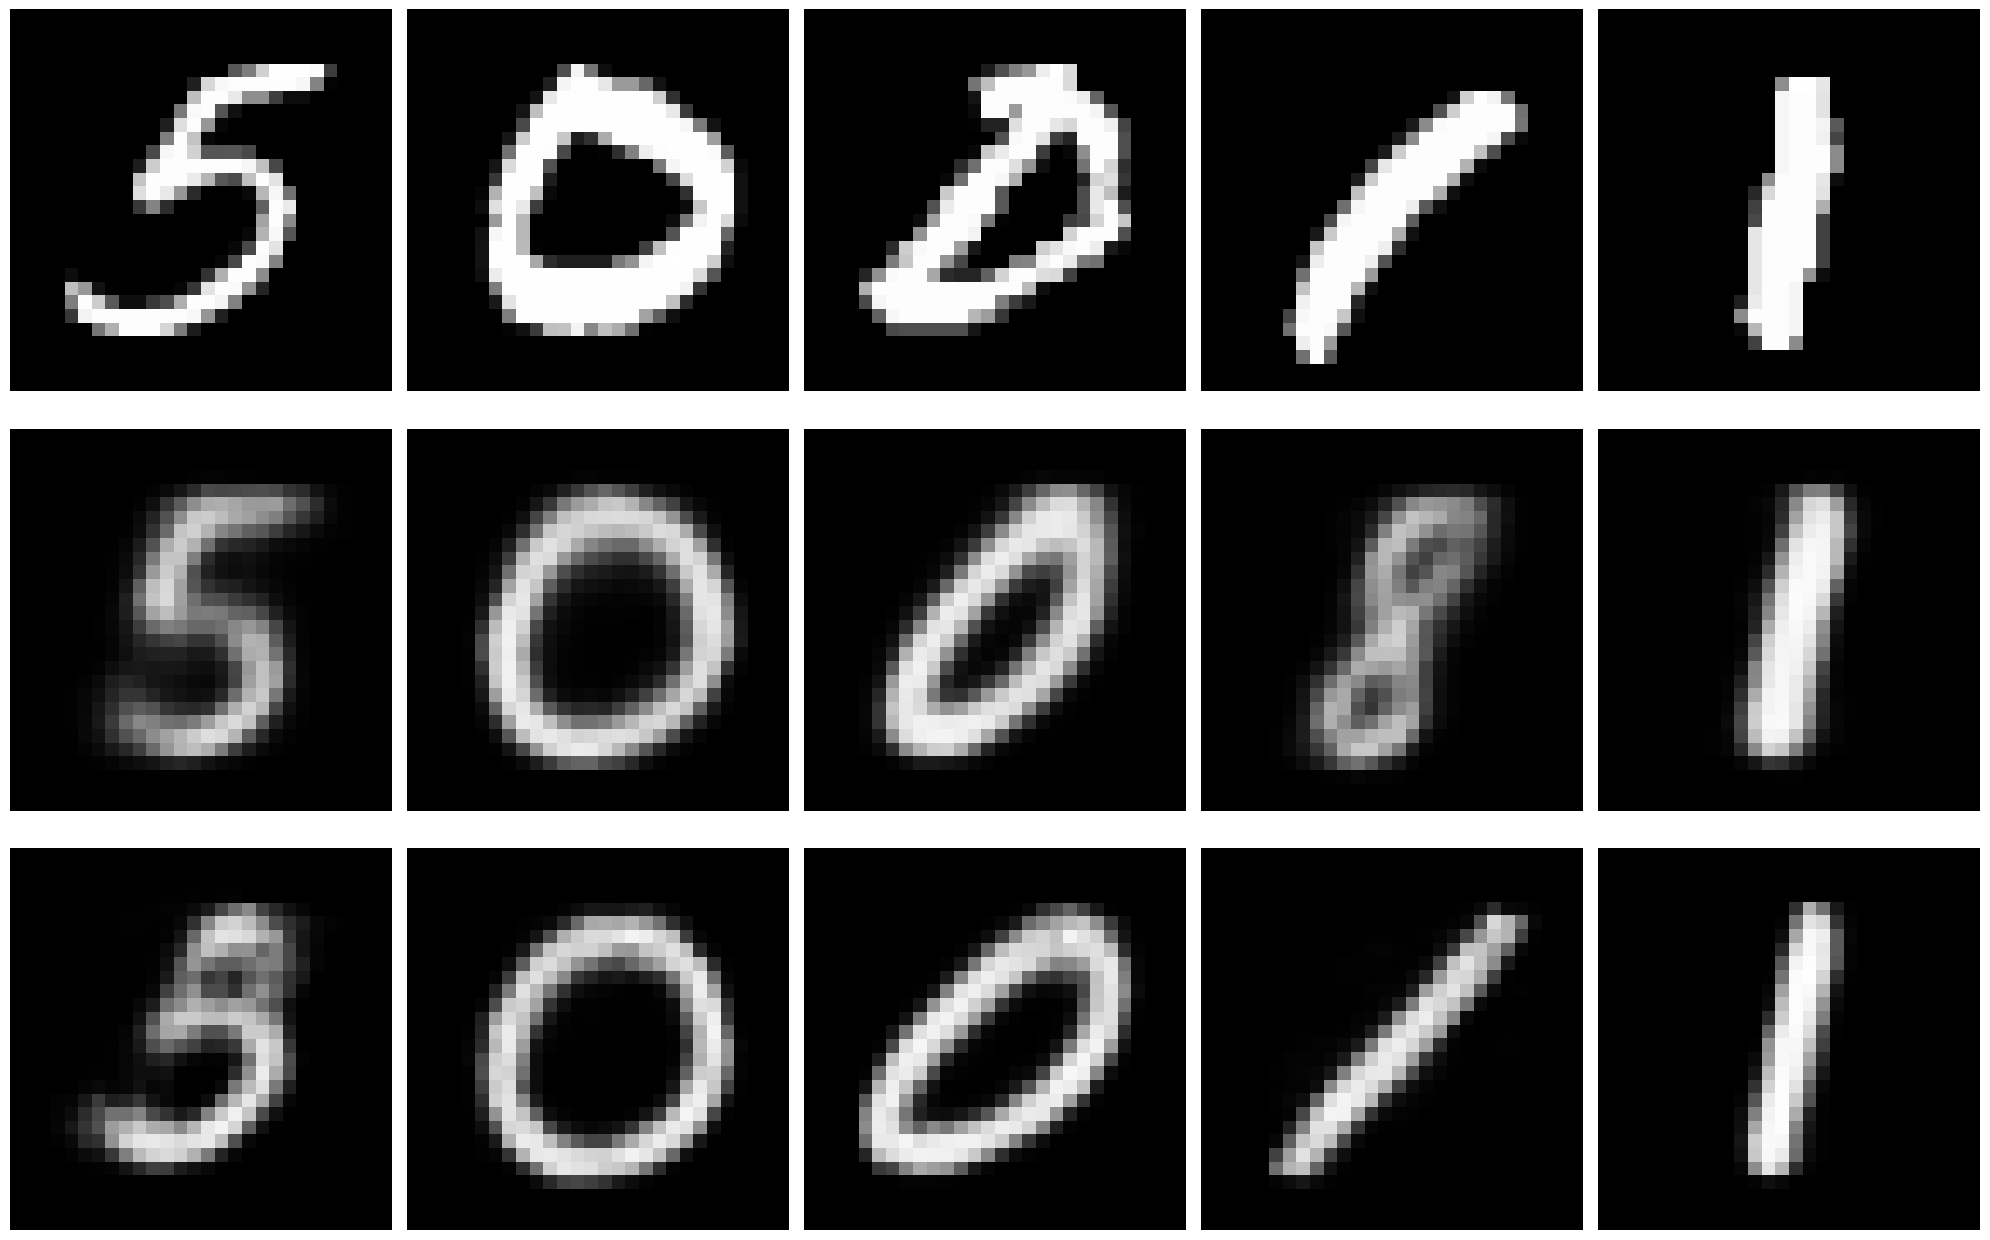

In [307]:
compare_with_vanilla(manager, 'pl f rate 16 +ce 16 30')

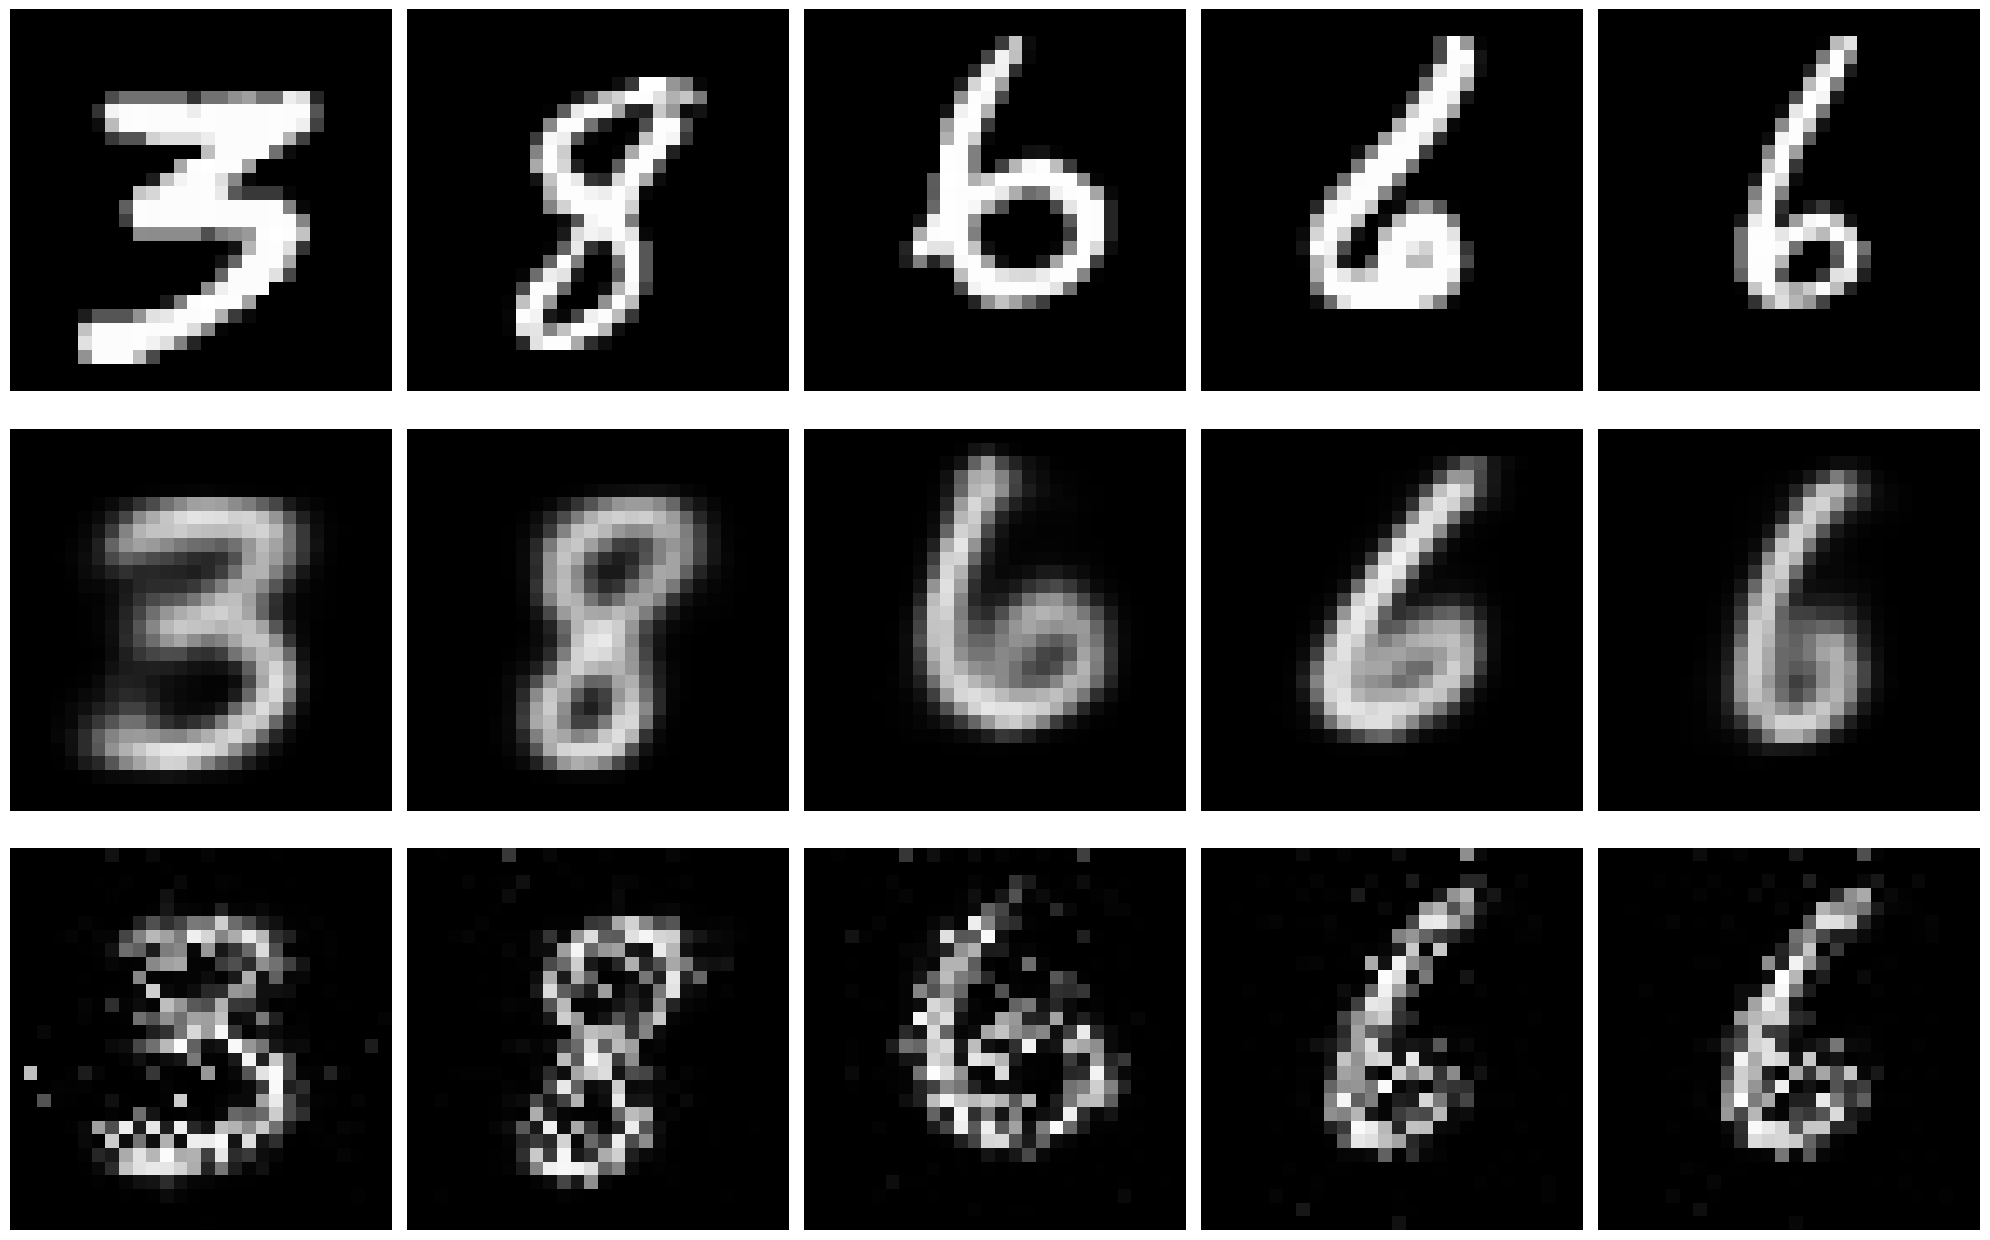

In [270]:
compare_with_vanilla(manager, 'pl f +ce 30')

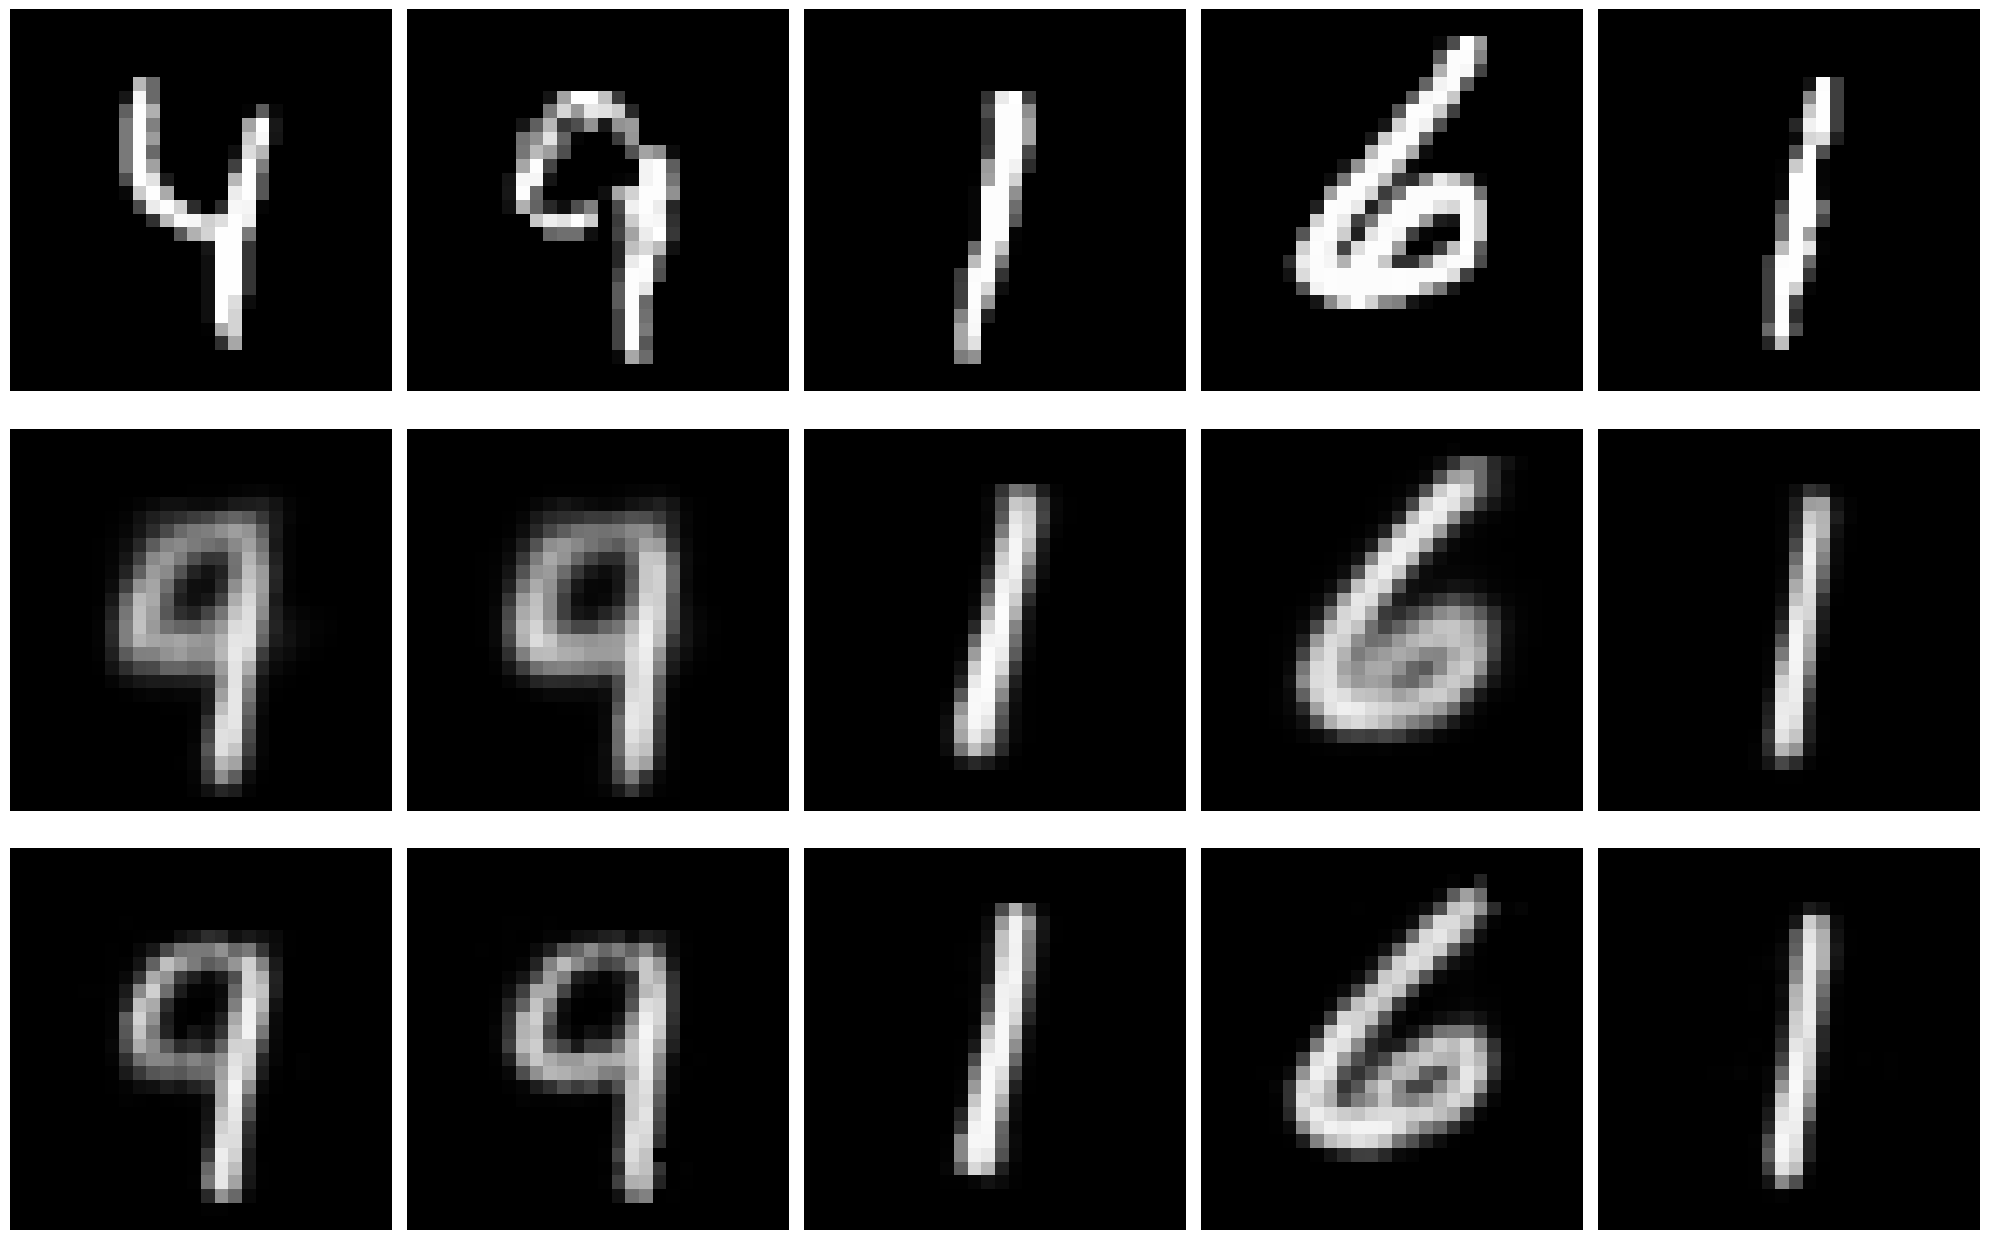

In [312]:
compare_with_vanilla(manager, 'pl f rate 16 30')

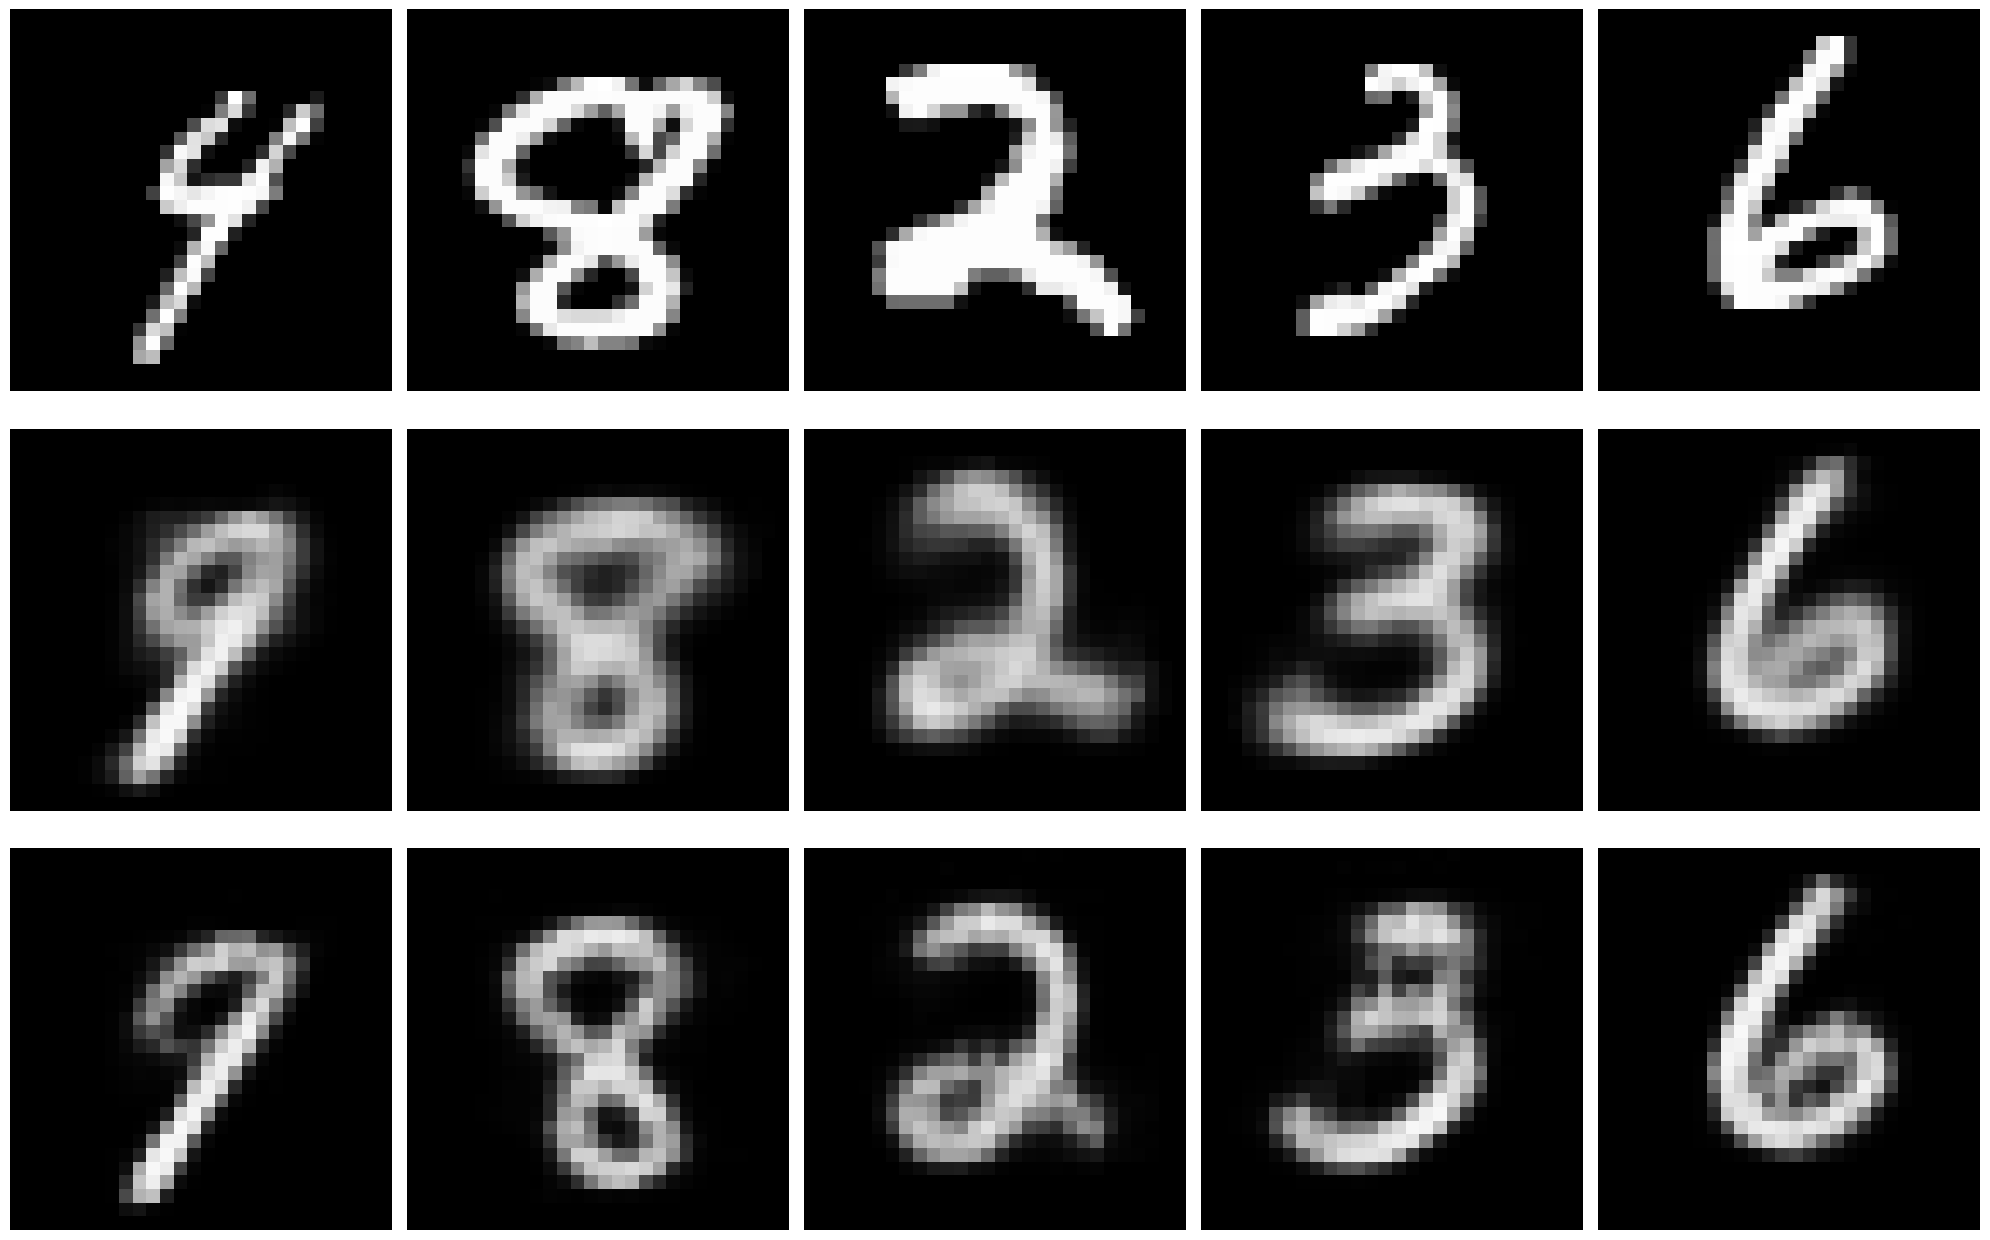

In [258]:
compare_with_vanilla(manager, 'pl f rate 8 +ce 4 30')

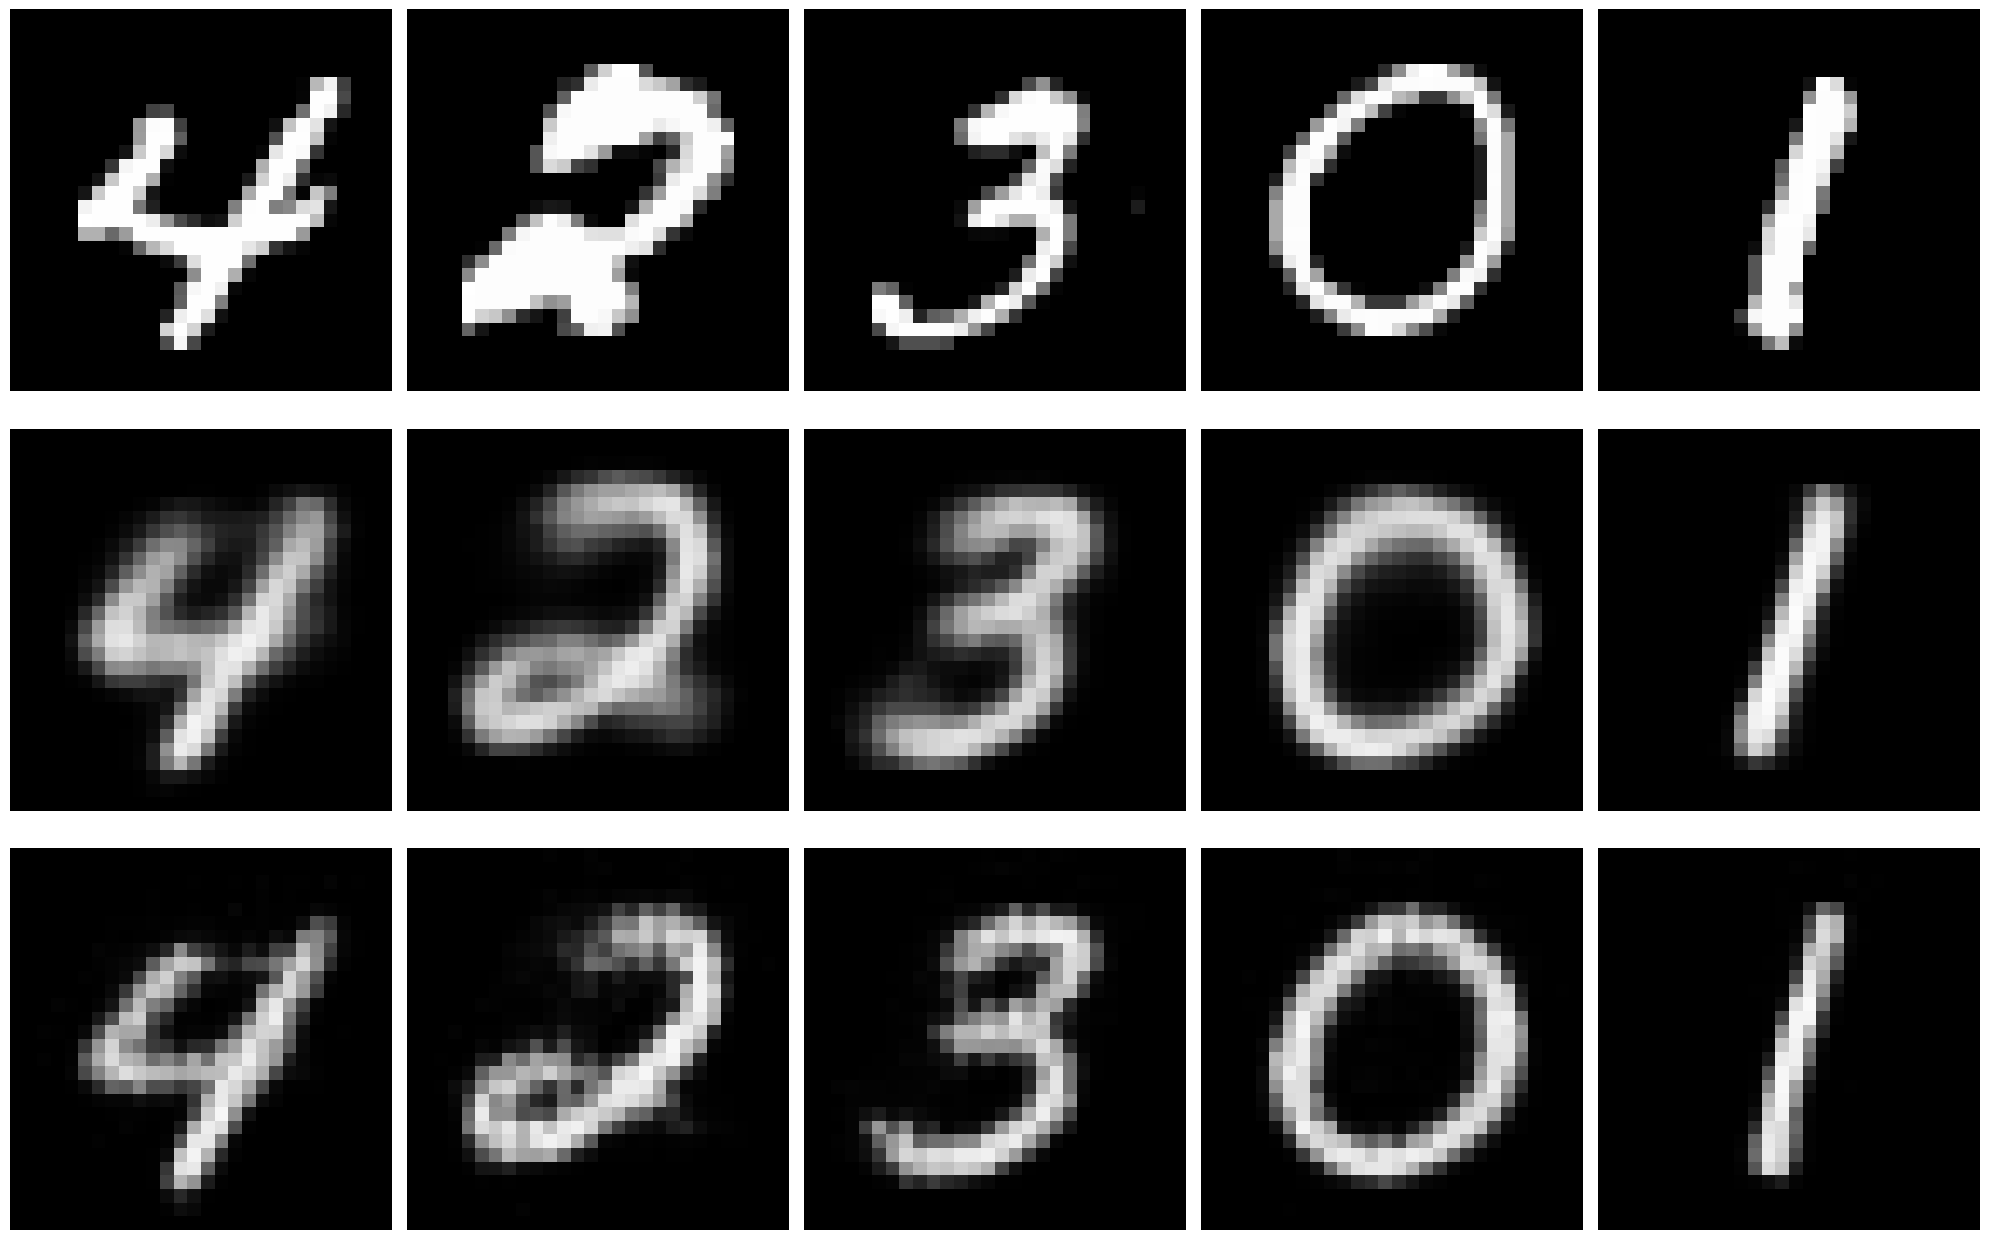

In [222]:
compare_with_vanilla(manager, 'pl f rate 4 +ce 4 30')

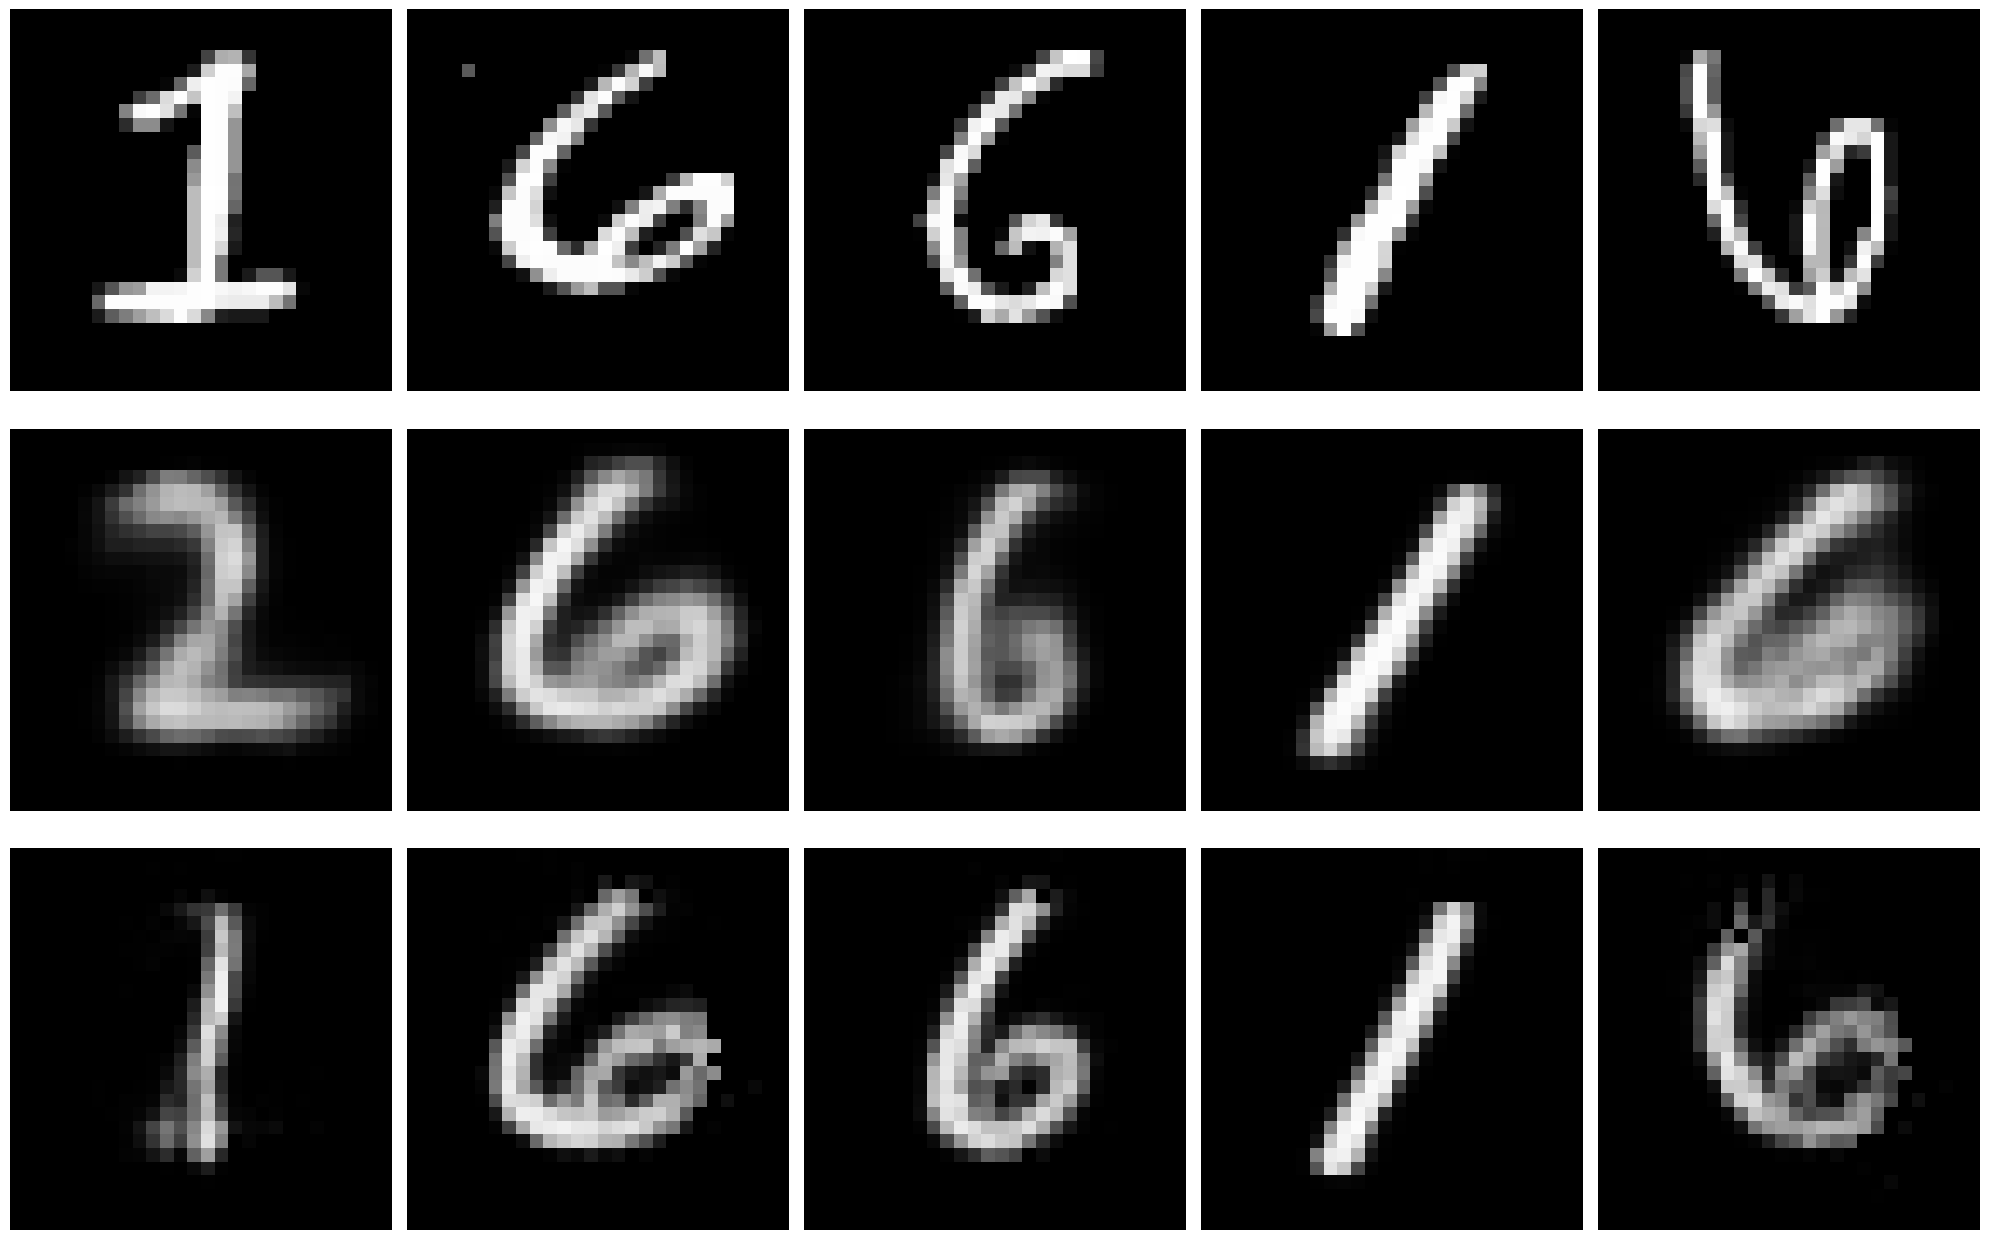

In [242]:
compare_with_vanilla(manager, 'pl f rate 8 30')

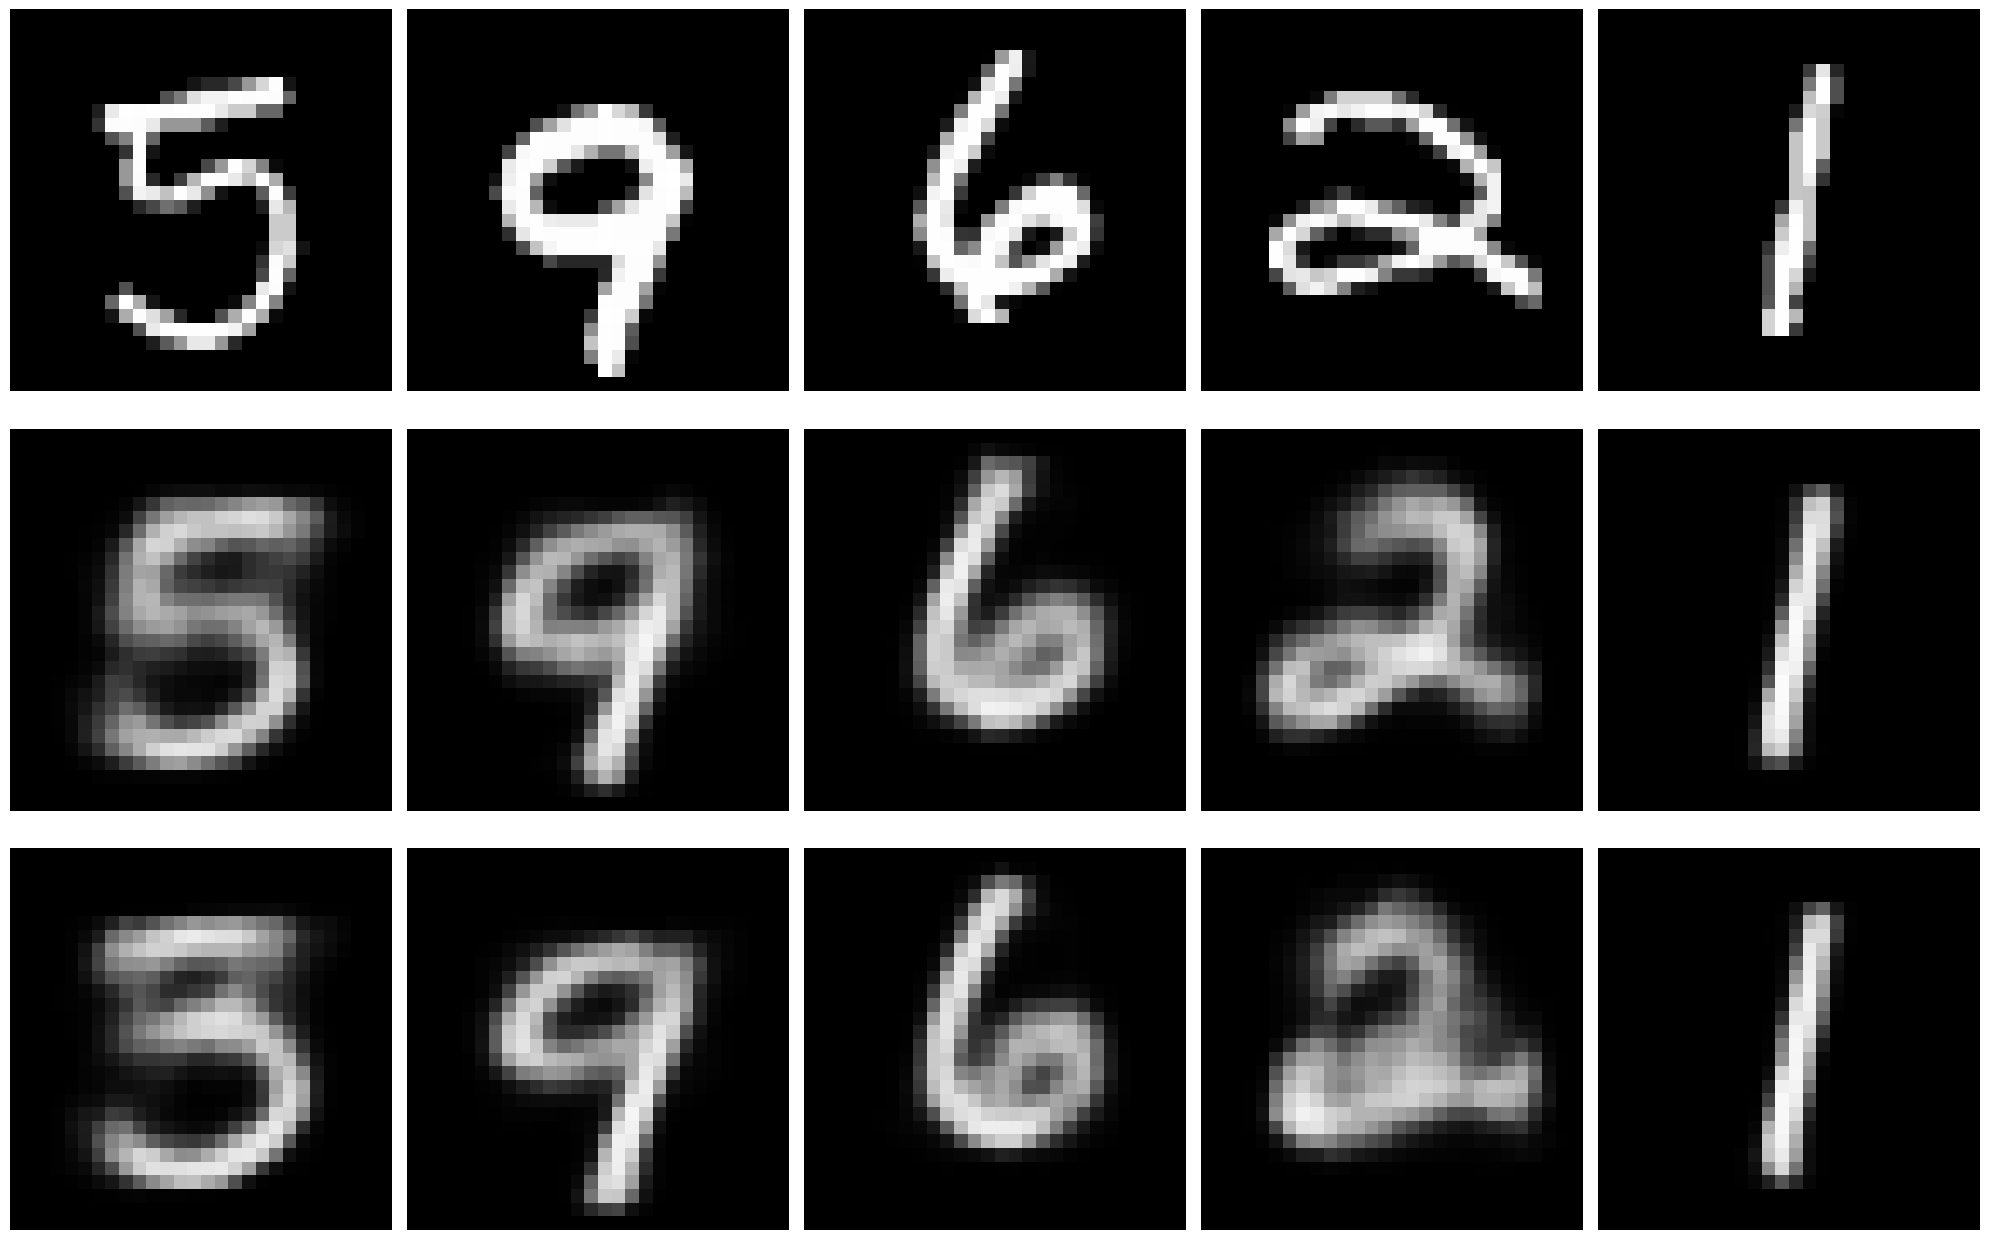

In [152]:
compare_with_vanilla(manager, 'pl rate 8 +ce 30')

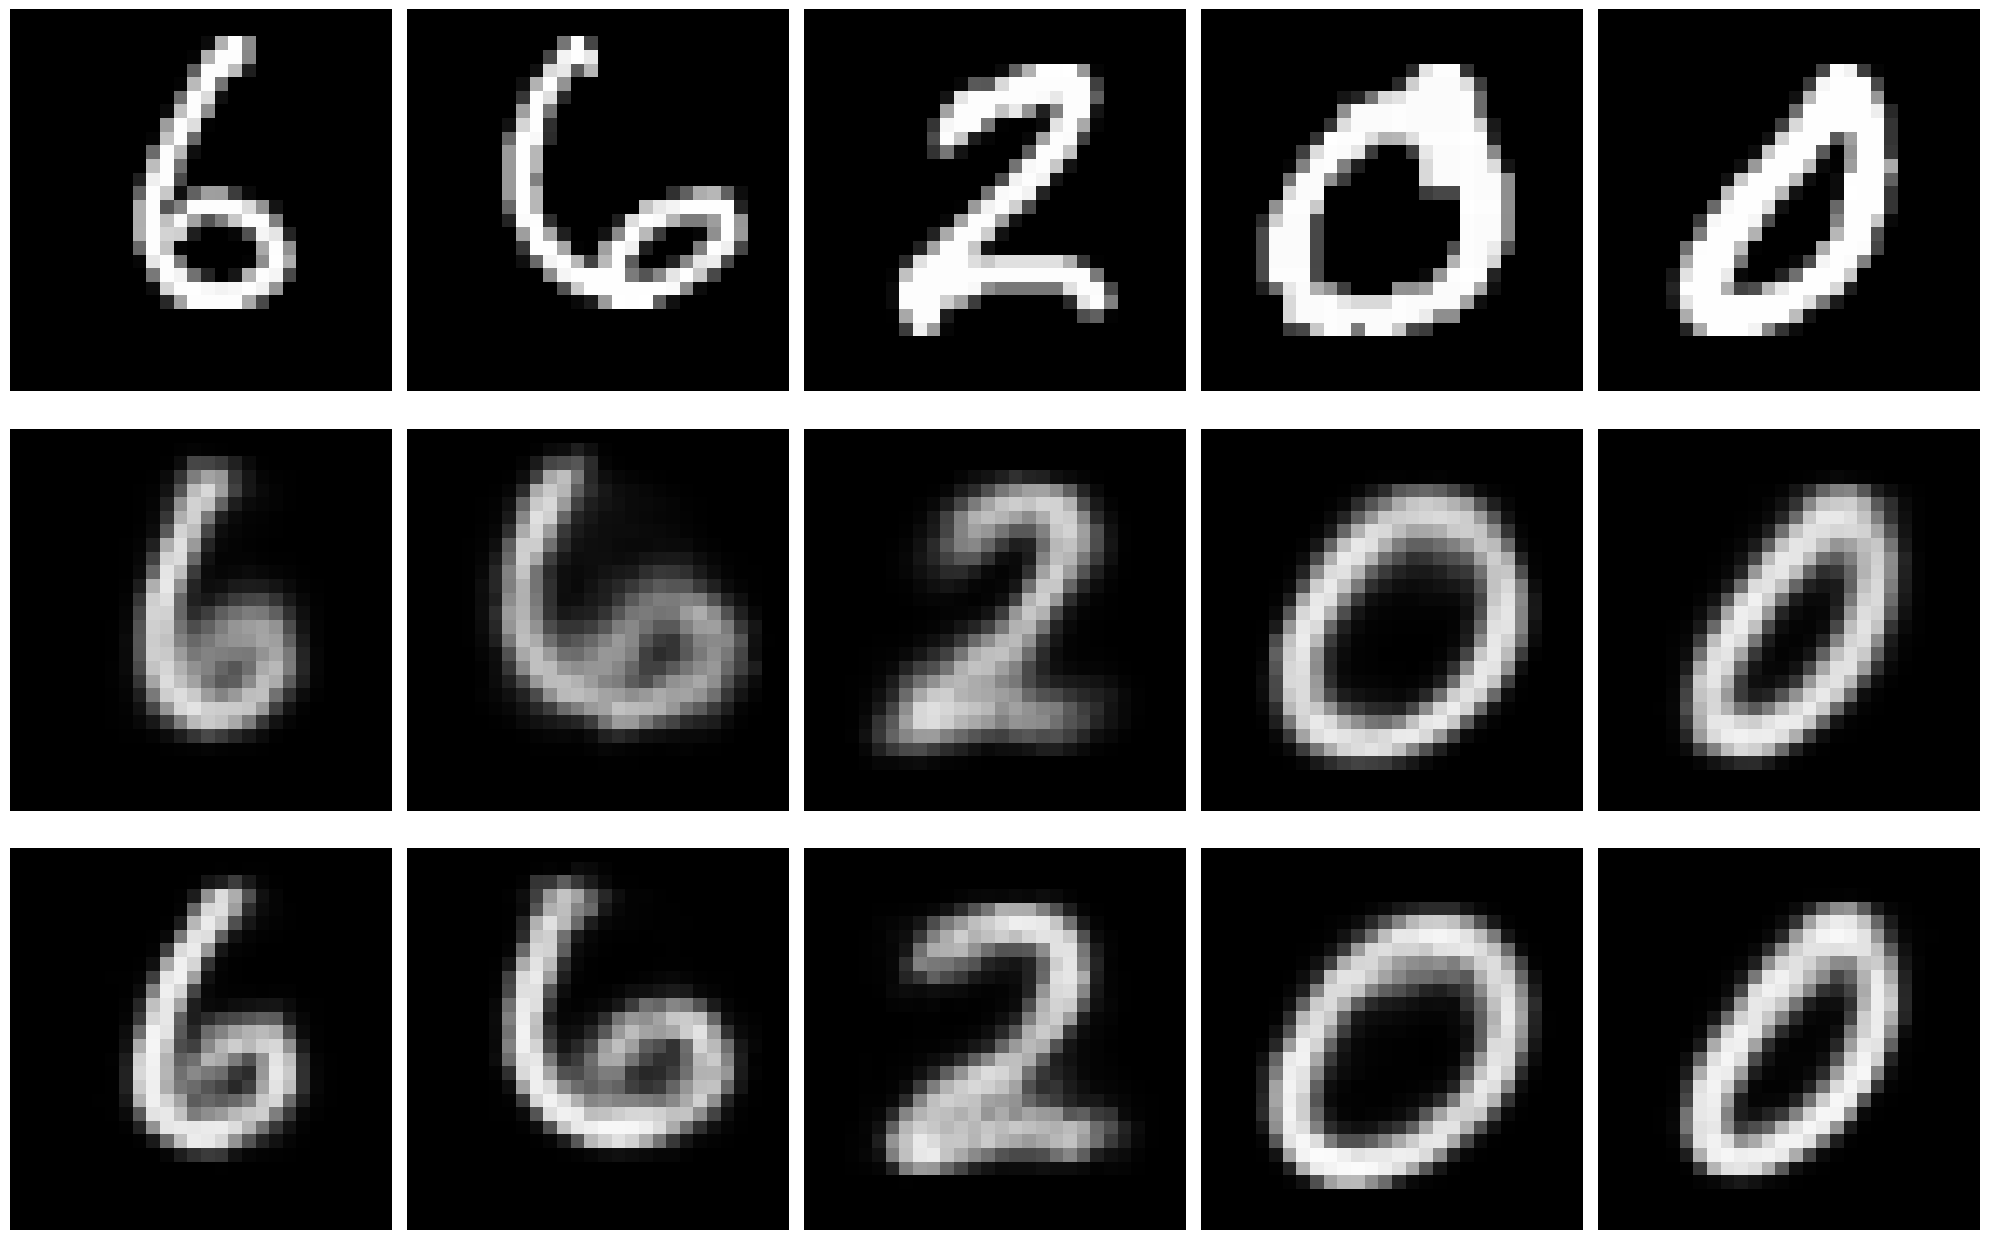

In [156]:
compare_with_vanilla(manager, 'pl rate 4 +ce 8 30')

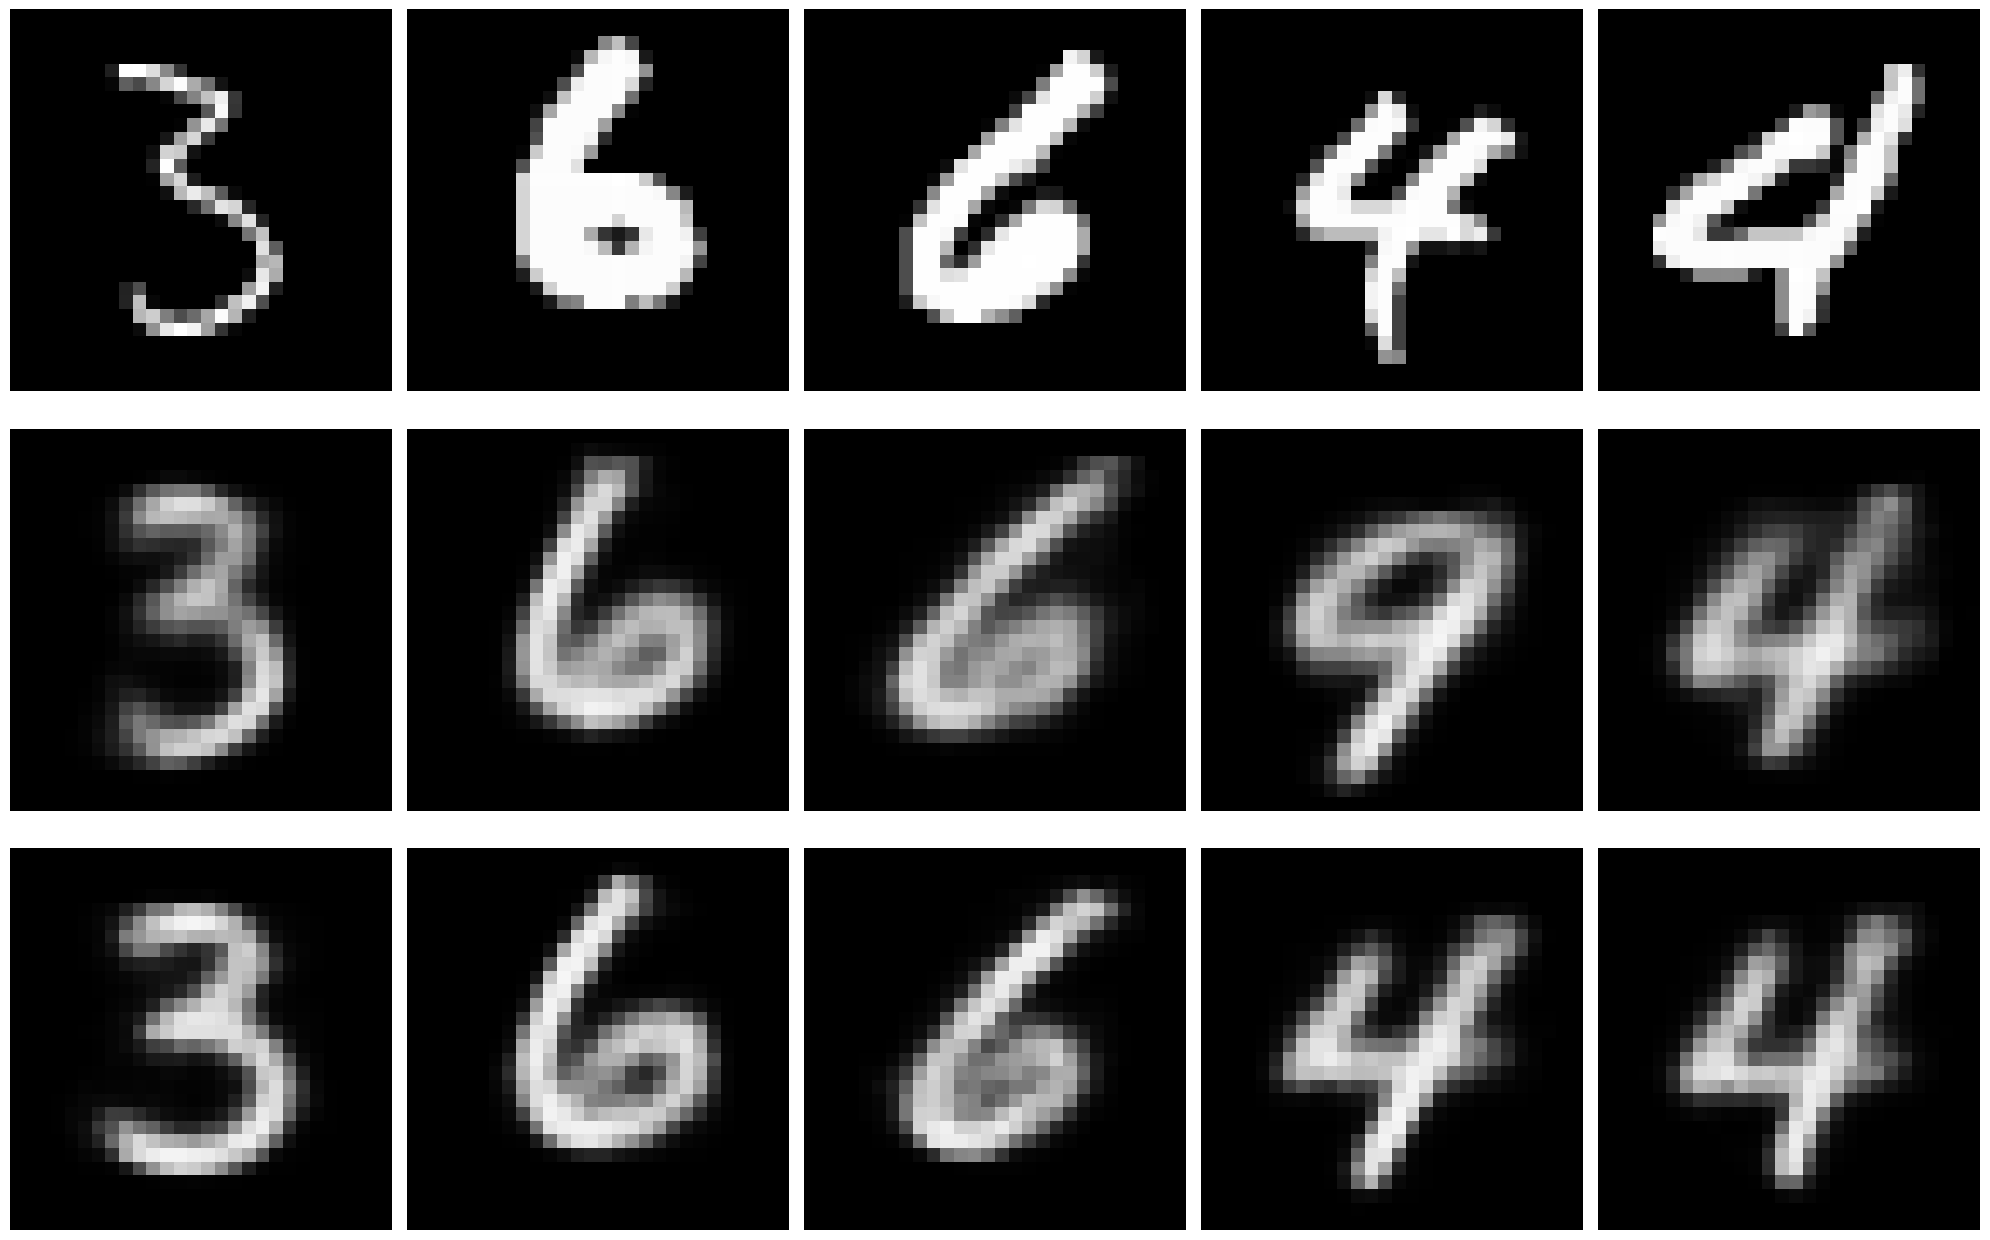

In [127]:
compare_with_vanilla(manager, 'pl rate 4 +ce 4 30')

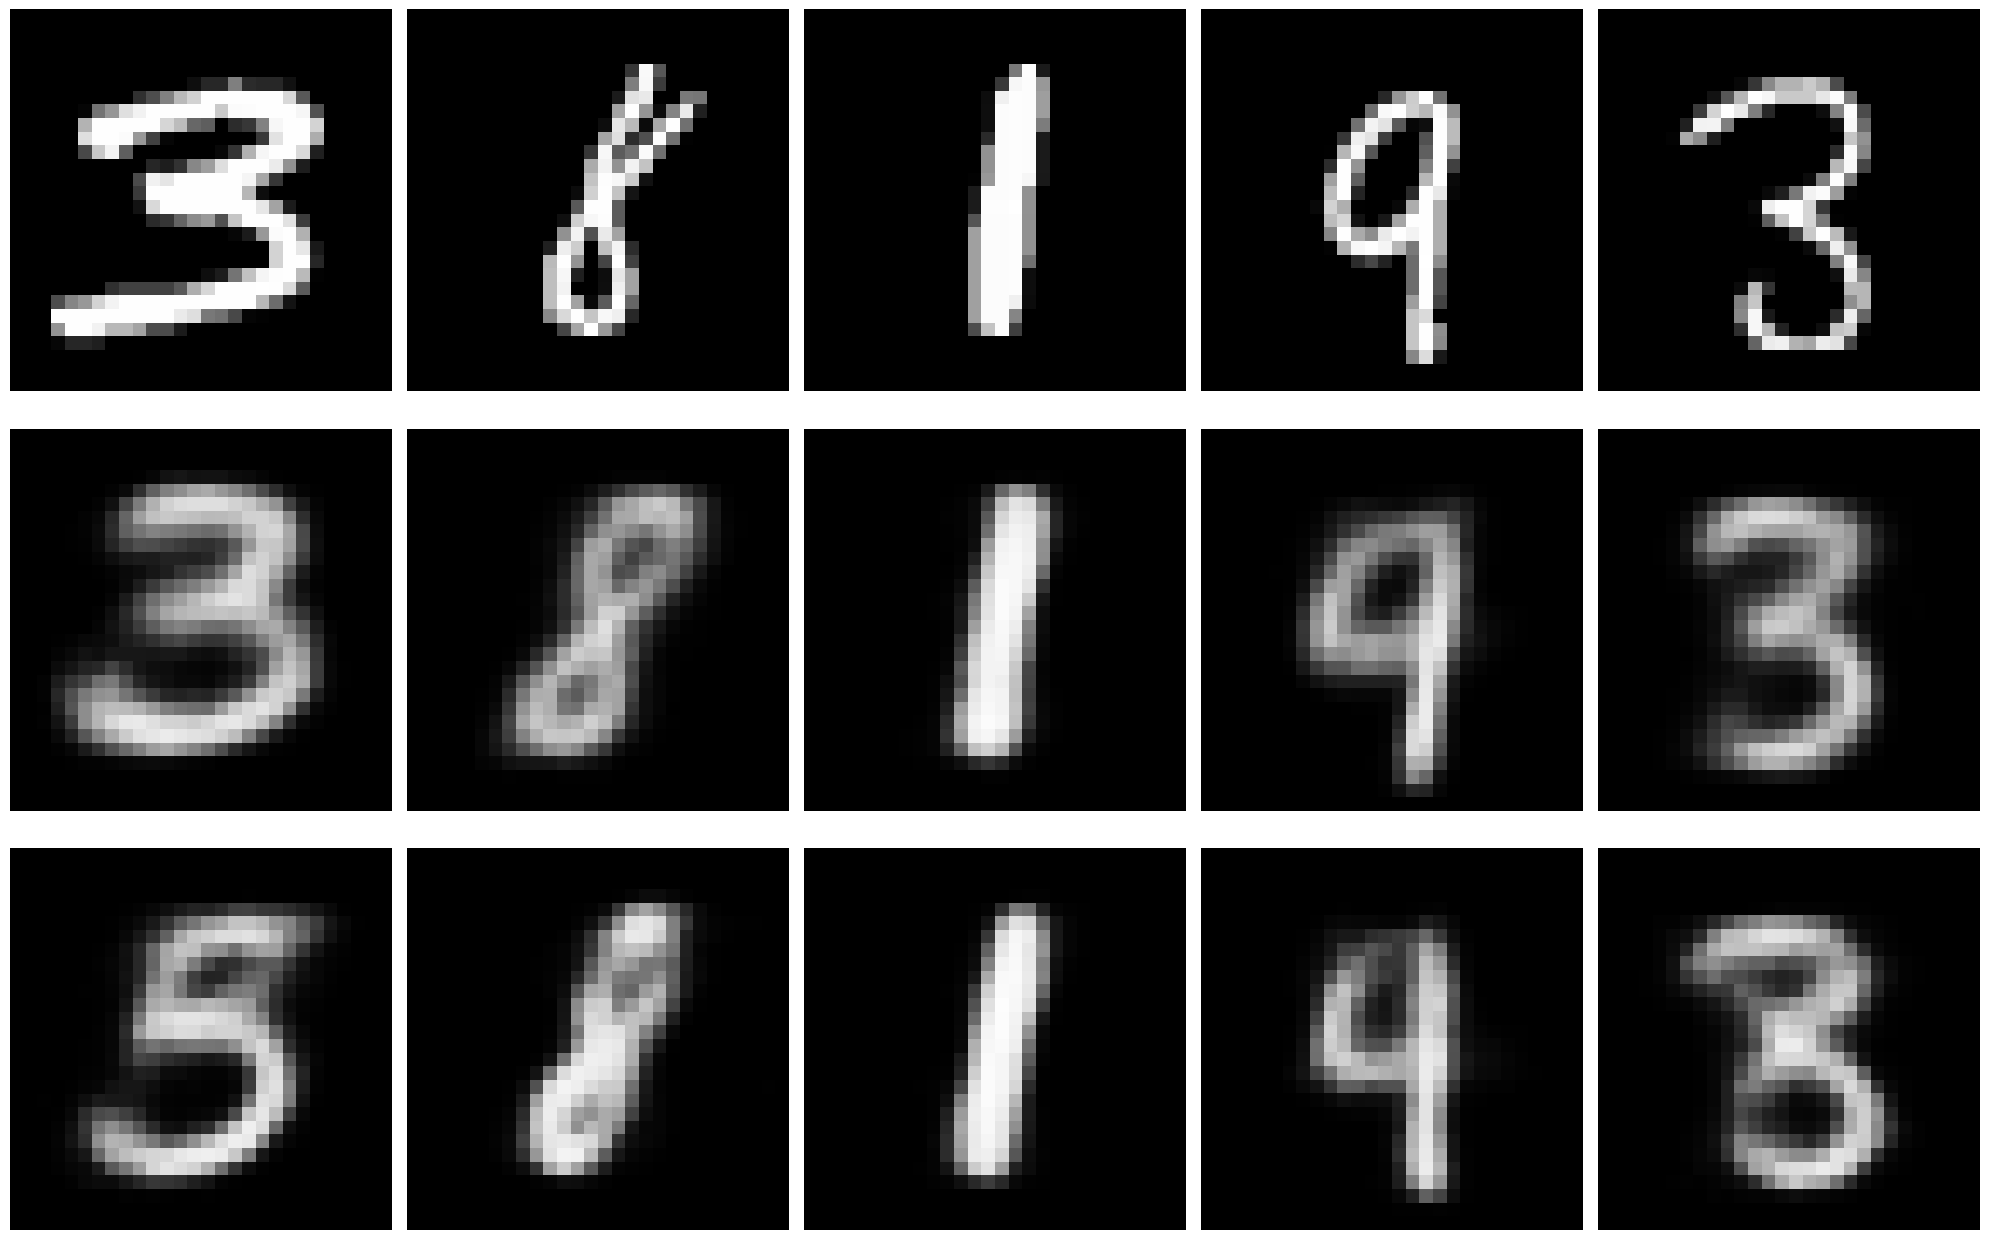

In [170]:
compare_with_vanilla(manager, 'pl rate 4 +ce 2 30')

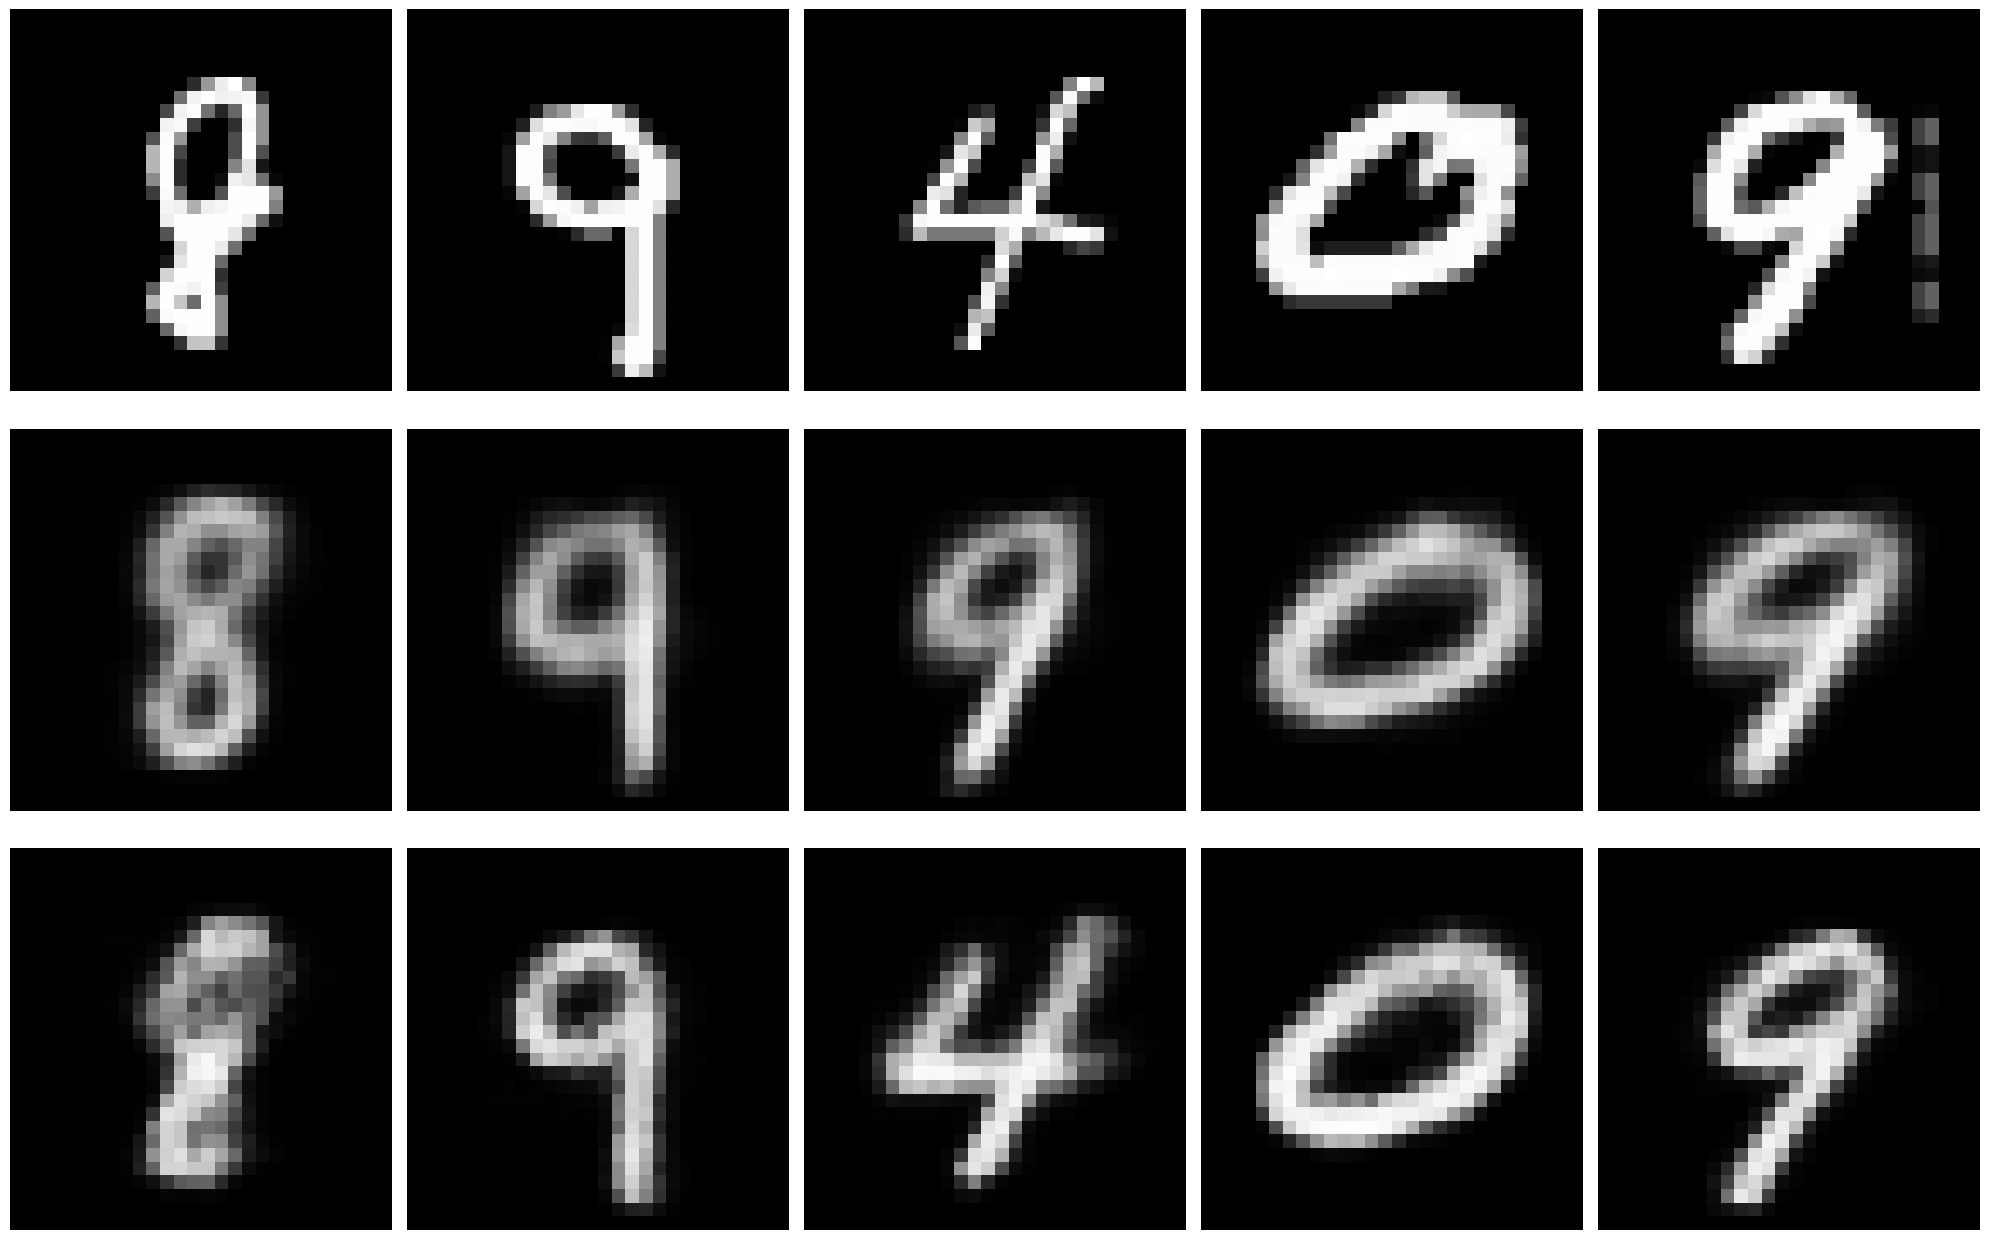

In [85]:
compare_with_vanilla(manager, 'pl rate 2 +ce 2 30')

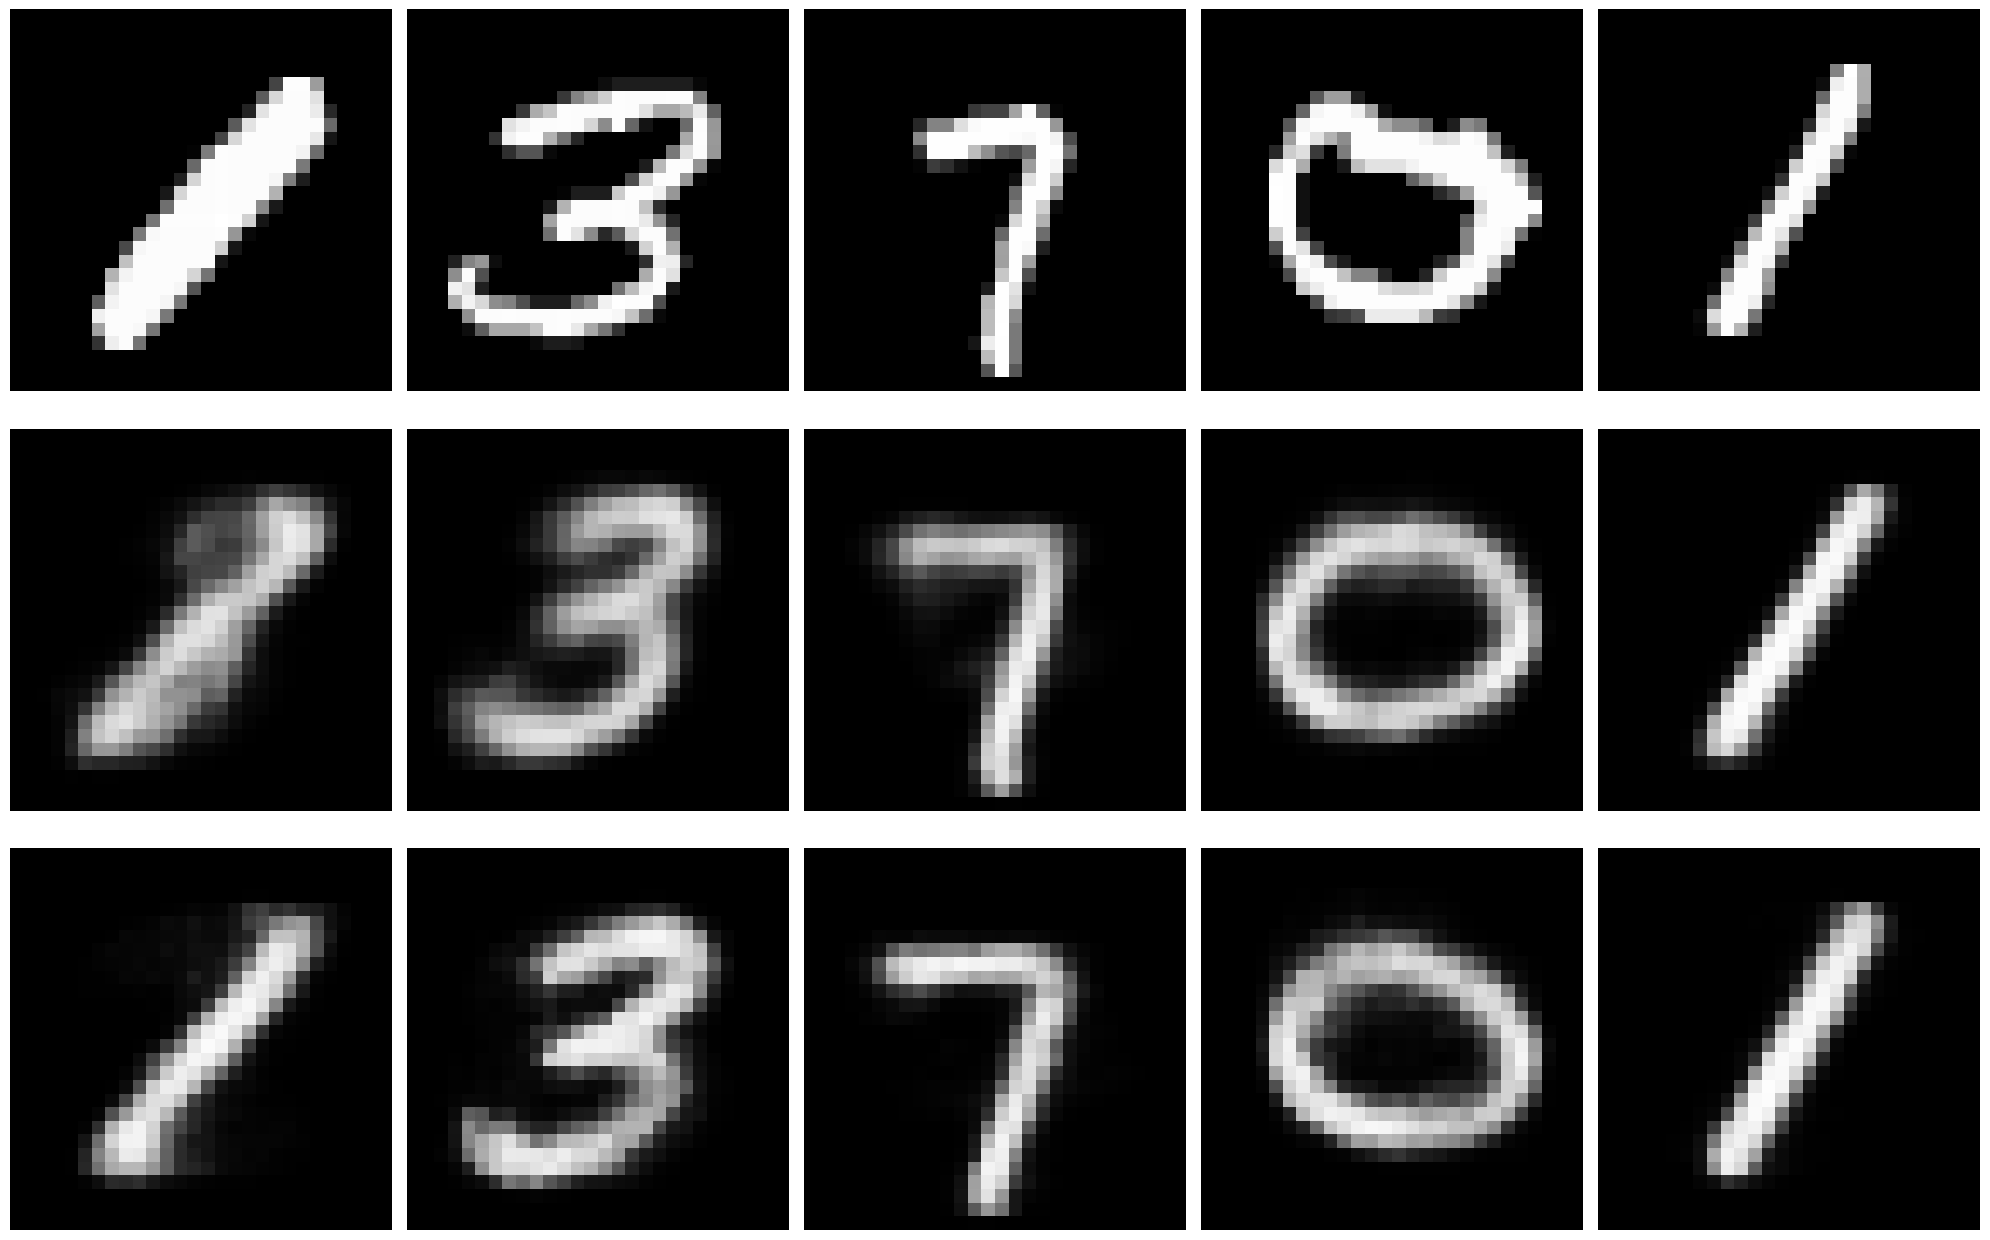

In [137]:
compare_with_vanilla(manager, 'pl rate 2 +ce 30')

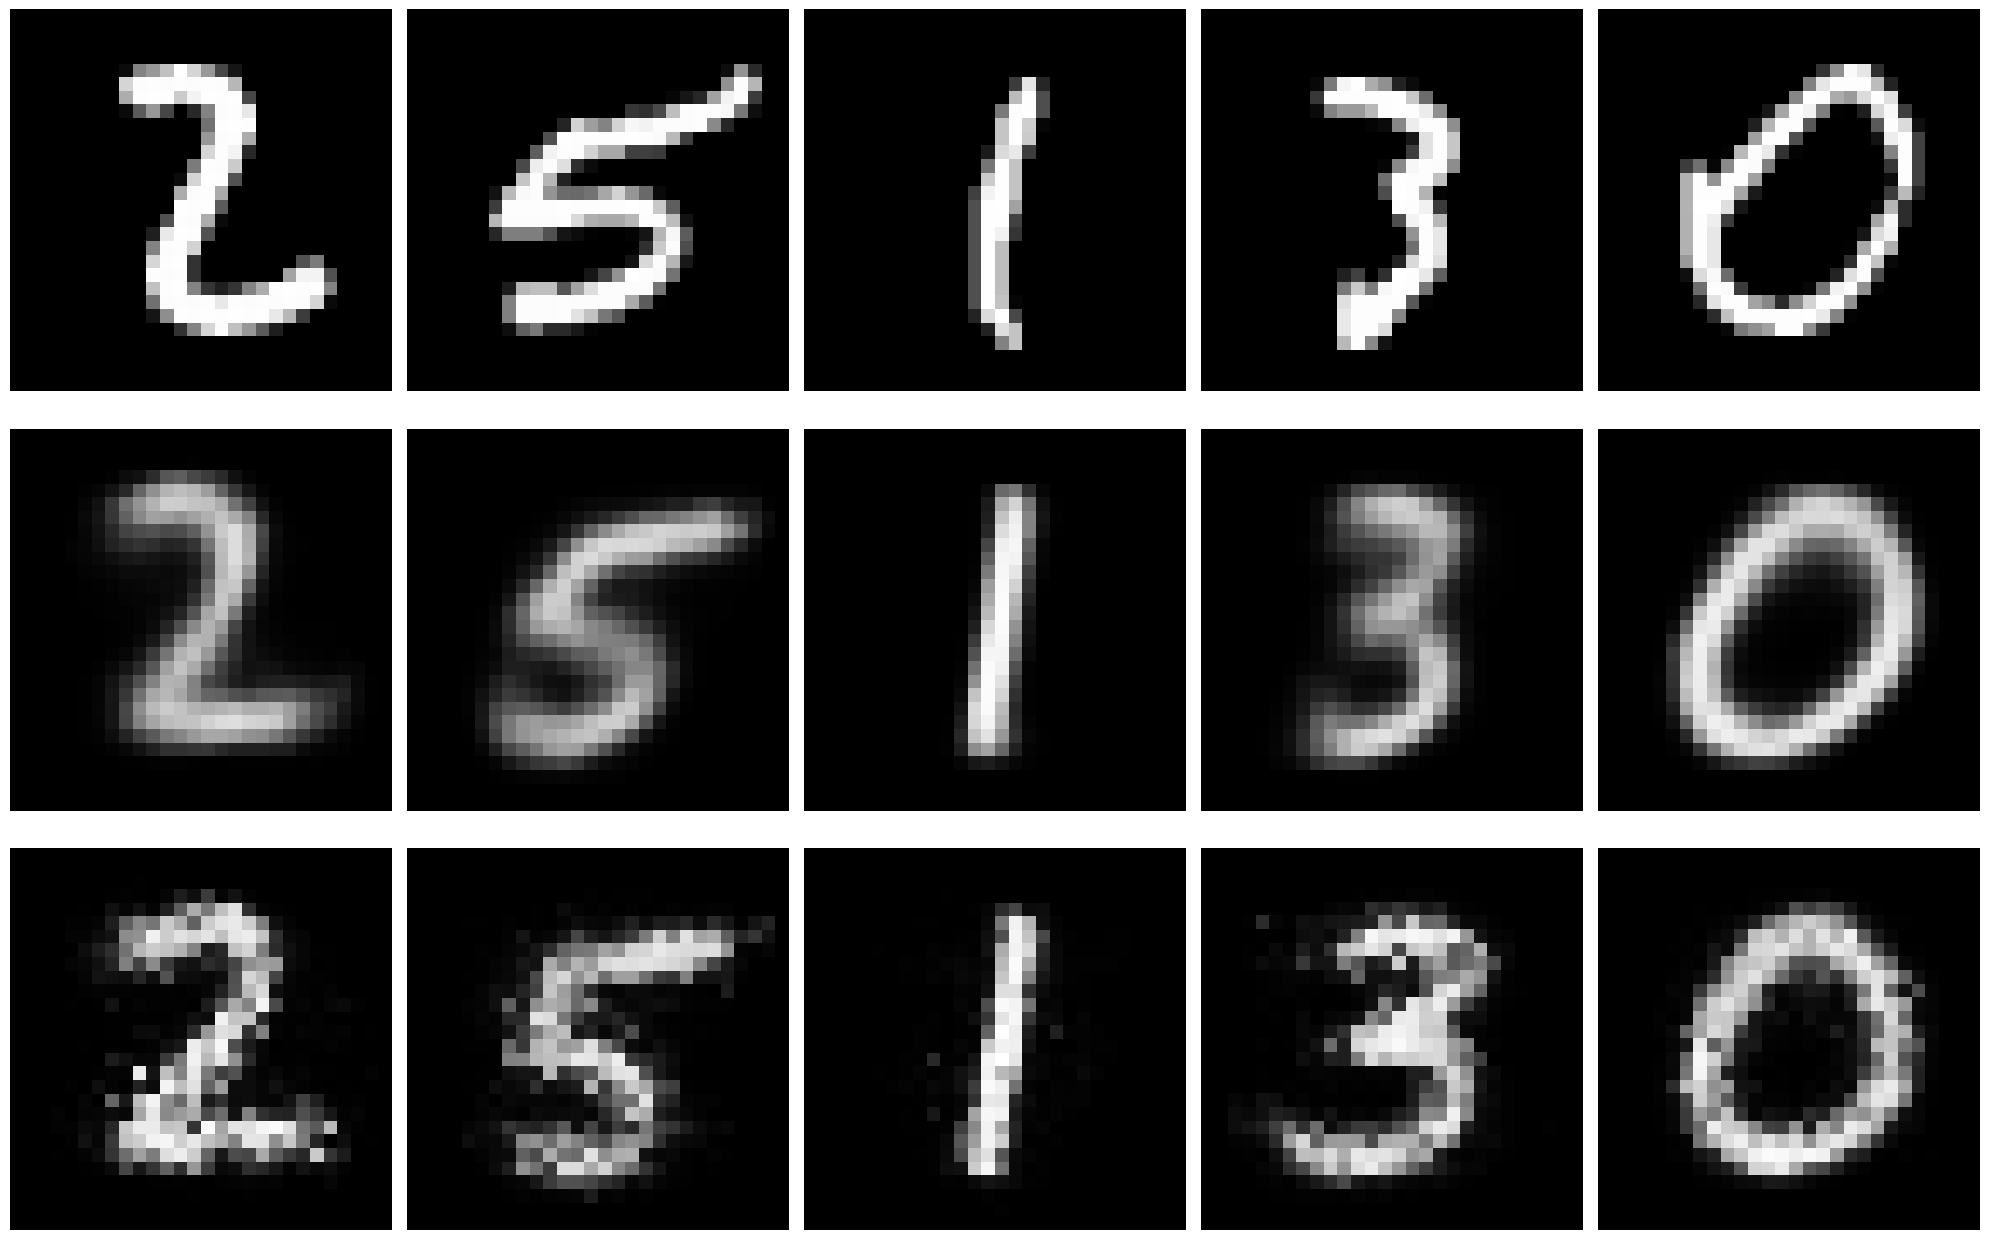

In [17]:
compare_with_vanilla(manager, 'pl +ce 30')